# Previsão de Votação de Deputados

### Sobre a tarefa

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).
2. Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. Isso implica, dentre outras coisas:
    - Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.   
    - Construir modelos de regressão com (ridge e lasso) e sem regularização.    
    - Considerar também modelos de regressão não paramétrica como K-NN.    
    - Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).    
    - Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.    
    - Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
    - Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.    
4. Responder:
    - Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.
    
A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

### Sobre os dados

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

|  Variável  | Tipo | Descrição |
|:------------|:------:|:-----------|
|"sequencial_candidato" | (character) | id do candidato|
|"nome"| (character) | |
|"uf" | (character) | |
|"partido" | (character)| |
|"quantidade_doacoes"| (integer)| |
|"quantidade_doadores"| (integer) | número de doadores diferentes|
|"total_receita" | (double) | soma em R\$ das doações |
|"media_receita" | (double) | média das doações |
|"recursos_de_outros_candidatos/comites" | (double) | quantia em R\$ das doações provenientes de outros candidatos ou comite partidário |
|"recursos_de_pessoas_fisicas" | (double) | quantia em R\$ das doações provenientes de outros CPFs |
|"recursos_de_pessoas_juridicas" | (double) | quantia em R\$ das doações provenientes de outros CNPJ |
|"recursos_proprios" | (double) | quantia em R\$ das doações provenientes do próprio candidato |
|"recursos_de_partido_politico" | (double) | quantia em R\$ das doações provenientes do partido político do candidato |
|**"votos"** | (integer) | **variável alvo**. Se refere ao número de votos na campanha de 2006 e 2010 |
|"quantidade_despesas" | (integer) | |
|"quantidade_fornecedores" | (integer) | número de fornecedores/despesas diferentes |
|"total_despesa" | (double) | soma em R$ das despesas de campanha |
|"media_despesa" | (double) | média das despesas de campanha |
|"cargo" |(character) | |
|"Sexo": | (character) | |
|"grau": | (character) | grau de instrução do candidato |
|"estado_civil" | (character) |
|"ocupacao" | (character) | ocupação do candidato |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import warnings

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import metrics

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Dados das eleições de  2006, 2010 e 2014

In [2]:
# Carregando o dataset eleições
eleicoes2006a2010 = pd.read_csv('eleicoes_2006_a_2010.csv')
eleicoes2014 = pd.read_csv('eleicoes_2014.csv')

### Conhecendo os dados

#### Eleições 2010 e 2014

In [3]:
# Visualizando os dados
eleicoes2006a2010.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [4]:
# Verificando o tamanho do dataset
print('O dataset contém', eleicoes2006a2010.shape[0], 'linhas e', \
      eleicoes2006a2010.shape[1], 'colunas')

O dataset contém 7330 linhas e 23 colunas


In [5]:
# Visualizando as colunas dos datasets
eleicoes2006a2010.columns

Index(['ano', 'sequencial_candidato', 'nome', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],
      dtype='object')

In [6]:
# Verificando os tipos de cada atributo dos dados
eleicoes2006a2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 23 columns):
ano                                      7330 non-null int64
sequencial_candidato                     7330 non-null int64
nome                                     7330 non-null object
uf                                       7330 non-null object
partido                                  7330 non-null object
quantidade_doacoes                       7330 non-null int64
quantidade_doadores                      7330 non-null int64
total_receita                            7169 non-null float64
media_receita                            7169 non-null float64
recursos_de_outros_candidatos/comites    4940 non-null float64
recursos_de_pessoas_fisicas              4647 non-null float64
recursos_de_pessoas_juridicas            3354 non-null float64
recursos_proprios                        4942 non-null float64
quantidade_despesas                      7330 non-null int64
quantidade_fornecedores 

In [7]:
# Decrevendo as variáveis numéricas
desc_int = eleicoes2006a2010.drop(['sequencial_candidato', 'ano'], axis=1).describe(include=[np.number])
desc_int.loc['count'] = desc_int.loc['count'].astype(int).astype(str)
desc_int.iloc[1:] = desc_int.iloc[1:].applymap('{:.0f}'.format)
desc_int.T

,count,mean,std,min,25%,50%,75%,max
quantidade_doacoes,7330,28,119,1,4,9,24,6997
quantidade_doadores,7330,26,104,1,4,8,22,5800
total_receita,7169,154490,395388,0,2700,12096,89300,4539727
media_receita,7169,5486,14117,0,623,1541,4662,500180
recursos_de_outros_candidatos/comites,4940,30021,128093,2,1180,3523,13276,3664205
recursos_de_pessoas_fisicas,4647,37309,82154,0,2000,9000,37562,1403049
recursos_de_pessoas_juridicas,3354,176119,351754,0,3422,26120,175522,3178226
recursos_proprios,4942,39142,183998,0,1177,5000,20275,5525600
quantidade_despesas,7330,133,417,1,6,21,83,9932
quantidade_fornecedores,7330,110,338,1,5,18,71,8359


In [8]:
# Decrevendo as variáveis categóricas
eleicoes2006a2010.describe(include=[np.object]).T

,count,unique,top,freq
nome,7330,6775,FRANCISCO LOPES DA SILVA,3
uf,7330,27,SP,1623
partido,7330,31,PT,606
cargo,7330,1,DEPUTADO FEDERAL,7330
sexo,7330,2,MASCULINO,6305
grau,7330,7,SUPERIOR COMPLETO,4255
estado_civil,7330,5,CASADO(A),4704
ocupacao,7330,175,OUTROS,819


In [9]:
# Medidas de dispersão
# Amplitude
maximo = eleicoes2006a2010[['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos']].max()
minimo = eleicoes2006a2010[['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos']].min()
amplitude = maximo - minimo
# Variância
variancia = eleicoes2006a2010.drop(['sequencial_candidato', 'ano'], axis=1).var()
# Desvio Padrão
desvio_padrao = eleicoes2006a2010.drop(['sequencial_candidato', 'ano'], axis=1).std()
# Desvio Absoluto
desvio_ab = eleicoes2006a2010.drop(['sequencial_candidato', 'ano'], axis=1).mad()
# Medidas
dispersao = pd.DataFrame({'amplitude':amplitude.astype(int),'variancia':variancia.astype(int), \
                          'desvio_padrao':desvio_padrao.astype(int), 'desvio_absoluto':desvio_ab.astype(int)})
dispersao

,amplitude,desvio_absoluto,desvio_padrao,variancia
quantidade_doacoes,6996,31,118,14079
quantidade_doadores,5799,28,103,10745
total_receita,4539726,213554,395387,156331638641
media_receita,500180,6215,14116,199276461
recursos_de_outros_candidatos/comites,3664202,42214,128093,16407878979
recursos_de_pessoas_fisicas,1403048,43326,82153,6749276308
recursos_de_pessoas_juridicas,3178225,217027,351754,123730935240
recursos_proprios,5525600,53800,183998,33855270189
quantidade_despesas,9931,174,416,173754
quantidade_fornecedores,8358,142,338,114577


Verificando os dados acima percebemos que muitos dos atributos numéricos tem um desvio padrão e variância altos, como é o caso de `total_receita, recursos_de_outros_candidatos/comites, recursos_de_pessoas_juridicas, recursos_proprios, total_despesa, votos, etc`. Estas medidas indicam que os valores estão muito espalhados e distante da média.

In [10]:
# Verificando a quantidade de valores faltantes por atributo
eleicoes2006a2010.isnull().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    2390
recursos_de_pessoas_fisicas              2683
recursos_de_pessoas_juridicas            3976
recursos_proprios                        2388
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

Verificamos que as colunas `total_receita, media_receita, recursos_de_outros_candidatos/comites, recursos_de_pessoas_fisicas, recursos_proprios` tem valores faltantes que precisarão ser tratados.

#### Eleições 2014

In [11]:
# Visualizando os dados
eleicoes2014.head()

,ano,sq_candidato,nome_candidato,sigla_uf,sigla_partido,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,...,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,descricao_cargo,sexo,grau_instrucao,estado_civil,descricao_ocupacao,votos
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,3,3,1580.00,526.666667,NaN,...,3,3,1580.00,526.666667,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES",37
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,5,5,3180.00,636.000000,NaN,...,6,5,3130.02,626.004000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE,383
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,40,38,333293.13,8770.871842,1923.07,...,145,139,326869.78,2351.581151,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS,26448
3,2014,10000000161,IDESIO LUIS FRANKE,AC,PT,29,29,156719.32,5404.114483,39122.32,...,136,121,241016.07,1991.868347,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO,9896
4,2014,10000000163,LEONARDO CUNHA DE BRITO,AC,PT,160,146,711083.00,4870.431507,10000.00,...,518,354,567401.15,1602.828107,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO,20876


In [13]:
# Verificando o tamanho do dataset
print('O dataset contém', eleicoes2014.shape[0], 'linhas e', \
      eleicoes2014.shape[1], 'colunas')

O dataset contém 4936 linhas e 23 colunas


In [14]:
# Visualizando as colunas dos datasets
eleicoes2014.columns

Index(['ano', 'sq_candidato', 'nome_candidato', 'sigla_uf', 'sigla_partido',
       'qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'descricao_cargo',
       'sexo', 'grau_instrucao', 'estado_civil', 'descricao_ocupacao',
       'votos'],
      dtype='object')

In [15]:
# Verificando os tipos de cada atributo dos dados
eleicoes2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4936 entries, 0 to 4935
Data columns (total 23 columns):
ano                                      4936 non-null int64
sq_candidato                             4936 non-null int64
nome_candidato                           4936 non-null object
sigla_uf                                 4936 non-null object
sigla_partido                            4936 non-null object
qtd_doacoes                              4936 non-null int64
qtd_doadores                             4936 non-null int64
total_receita                            4936 non-null float64
media_receita                            4936 non-null float64
recursos de outros candidatos/comitês    3191 non-null float64
recursos de pessoas físicas              3727 non-null float64
recursos de pessoas jurídicas            1714 non-null float64
recursos próprios                        2860 non-null float64
qtd_despesas                             4936 non-null int64
qtd_fornecedores        

In [17]:
# Decrevendo as variáveis numéricas
desc_int = eleicoes2014.drop(['sq_candidato', 'ano'], axis=1).describe(include=[np.number])
desc_int.loc['count'] = desc_int.loc['count'].astype(int).astype(str)
desc_int.iloc[1:] = desc_int.iloc[1:].applymap('{:.0f}'.format)
desc_int.T

,count,mean,std,min,25%,50%,75%,max
qtd_doacoes,4936,25,50,1,5,9,22,928
qtd_doadores,4936,21,41,1,4,9,19,873
total_receita,4936,200554,534715,0,3026,11435,88827,5836140
media_receita,4936,6135,14250,0,607,1417,4599,281250
recursos de outros candidatos/comitês,3191,33500,113927,0,1088,4205,19212,1788100
recursos de pessoas físicas,3727,40846,108591,0,1100,4500,27460,1826762
recursos de pessoas jurídicas,1714,203696,425661,1,3000,27936,200754,3828338
recursos próprios,2860,43563,175777,0,1200,5005,21834,3752000
qtd_despesas,4936,148,441,1,6,17,72,6413
qtd_fornecedores,4936,117,347,1,5,15,60,5170


In [18]:
# Decrevendo as variáveis categóricas
eleicoes2014.describe(include=[np.object]).T

,count,unique,top,freq
nome_candidato,4936,4929,ANTONIO FERREIRA PINTO,2
sigla_uf,4936,27,SP,1084
sigla_partido,4936,32,PSB,325
descricao_cargo,4936,1,DEPUTADO FEDERAL,4936
sexo,4936,2,MASCULINO,3607
grau_instrucao,4936,7,SUPERIOR COMPLETO,2707
estado_civil,4936,5,CASADO(A),2841
descricao_ocupacao,4936,159,OUTROS,651


In [19]:
eleicoes2014.columns

Index(['ano', 'sq_candidato', 'nome_candidato', 'sigla_uf', 'sigla_partido',
       'qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'descricao_cargo',
       'sexo', 'grau_instrucao', 'estado_civil', 'descricao_ocupacao',
       'votos'],
      dtype='object')

In [21]:
# Medidas de dispersão
# Amplitude
maximo = eleicoes2014[['qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'votos']].max()
minimo = eleicoes2014[['qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'votos']].min()
amplitude = maximo - minimo
# Variância
variancia = eleicoes2014.drop(['sq_candidato', 'ano'], axis=1).var()
# Desvio Padrão
desvio_padrao = eleicoes2014.drop(['sq_candidato', 'ano'], axis=1).std()
# Desvio Absoluto
desvio_ab = eleicoes2014.drop(['sq_candidato', 'ano'], axis=1).mad()
# Medidas
dispersao = pd.DataFrame({'amplitude':amplitude.astype(int),'variancia':variancia.astype(int), \
                          'desvio_padrao':desvio_padrao.astype(int), 'desvio_absoluto':desvio_ab.astype(int)})
dispersao

,amplitude,desvio_absoluto,desvio_padrao,variancia
qtd_doacoes,927,25,49,2498
qtd_doadores,872,21,40,1671
total_receita,5836139,288958,534714,285919899046
media_receita,281249,7342,14250,203070868
recursos de outros candidatos/comitês,1788100,45390,113927,12979474566
recursos de pessoas físicas,1826761,54308,108590,11791903833
recursos de pessoas jurídicas,3828336,255921,425661,181187687277
recursos próprios,3751999,60245,175776,30897490030
qtd_despesas,6412,204,441,194615
qtd_fornecedores,5169,159,347,120727


Verificando os dados acima percebemos que muitos dos atributos numéricos tem um desvio padrão e variância altos, muito maiores que as do dataset das eleições de 2006 e 2010. Estas medidas indicam que os valores estão muito espalhados e distante da média e podem influenciar no modelo que foi treinado com um dataset com variância menor.

In [22]:
# Verificando a quantidade de valores faltantes por atributo
eleicoes2014.isnull().sum()

ano                                         0
sq_candidato                                0
nome_candidato                              0
sigla_uf                                    0
sigla_partido                               0
qtd_doacoes                                 0
qtd_doadores                                0
total_receita                               0
media_receita                               0
recursos de outros candidatos/comitês    1745
recursos de pessoas físicas              1209
recursos de pessoas jurídicas            3222
recursos próprios                        2076
qtd_despesas                                0
qtd_fornecedores                            0
total_despesa                               0
media_despesa                               0
descricao_cargo                             0
sexo                                        0
grau_instrucao                              0
estado_civil                                0
descricao_ocupacao                

Verificamos que as colunas `recursos_de_outros_candidatos/comites, recursos_de_pessoas_fisicas, recursos de pessoas jurídicas e recursos_proprios` tem valores faltantes que precisarão ser tratados.

## Pré-processamento dos dados 

#### Unificando o nome das colunas nos dois datasets

Tomaremos como base os nomes das colunas do dataset eleicoies_2006a2010.csv

In [24]:
old_names = ['ano', 'sq_candidato', 'nome_candidato', 'sigla_uf', 'sigla_partido',
       'qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'descricao_cargo',
       'sexo', 'grau_instrucao', 'estado_civil', 'descricao_ocupacao',
       'votos'] 
new_names = ['ano', 'sequencial_candidato', 'nome', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'] 
eleicoes2014.rename(columns=dict(zip(old_names, new_names)), inplace=True) 

#### Separando os datasets de treino e teste

In [25]:
# Separando os datasets para treino e teste
# Treino
# Selecionando os atributos a serem utilizados no treino
train = eleicoes2006a2010.loc[:,['uf', 'partido','quantidade_doacoes', 'quantidade_doadores', 
       'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]
# Teste
# Selecionando os atributos a serem utilizados no teste
test = eleicoes2014.loc[:,['uf', 'partido','quantidade_doacoes', 'quantidade_doadores', 
       'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]


Aguns atributos foram desconsiderados, entre eles estão:

 - *Ano, sequencial candidato*, pois são atributos que não estão relacionados ao desempenho do candidato.
 
 - *Cargo*, todos os candidatos concorrem ao mesmo cargo.

 - *Nome*, por gerar um número considerável de atributos que ao meu ver dificulta a criação dos modelos.

 - *Ocupação*, devido a quantidade de ocupações indefinidas.

### Preparando os dados para utilizar no modelo

In [26]:
# Concatenando os dataframes de treino e teste
df = pd.concat((train,test))
# Separando os atributos preditores do atributo alvo
X = df.loc[:,'uf':'estado_civil']
y = df['votos']

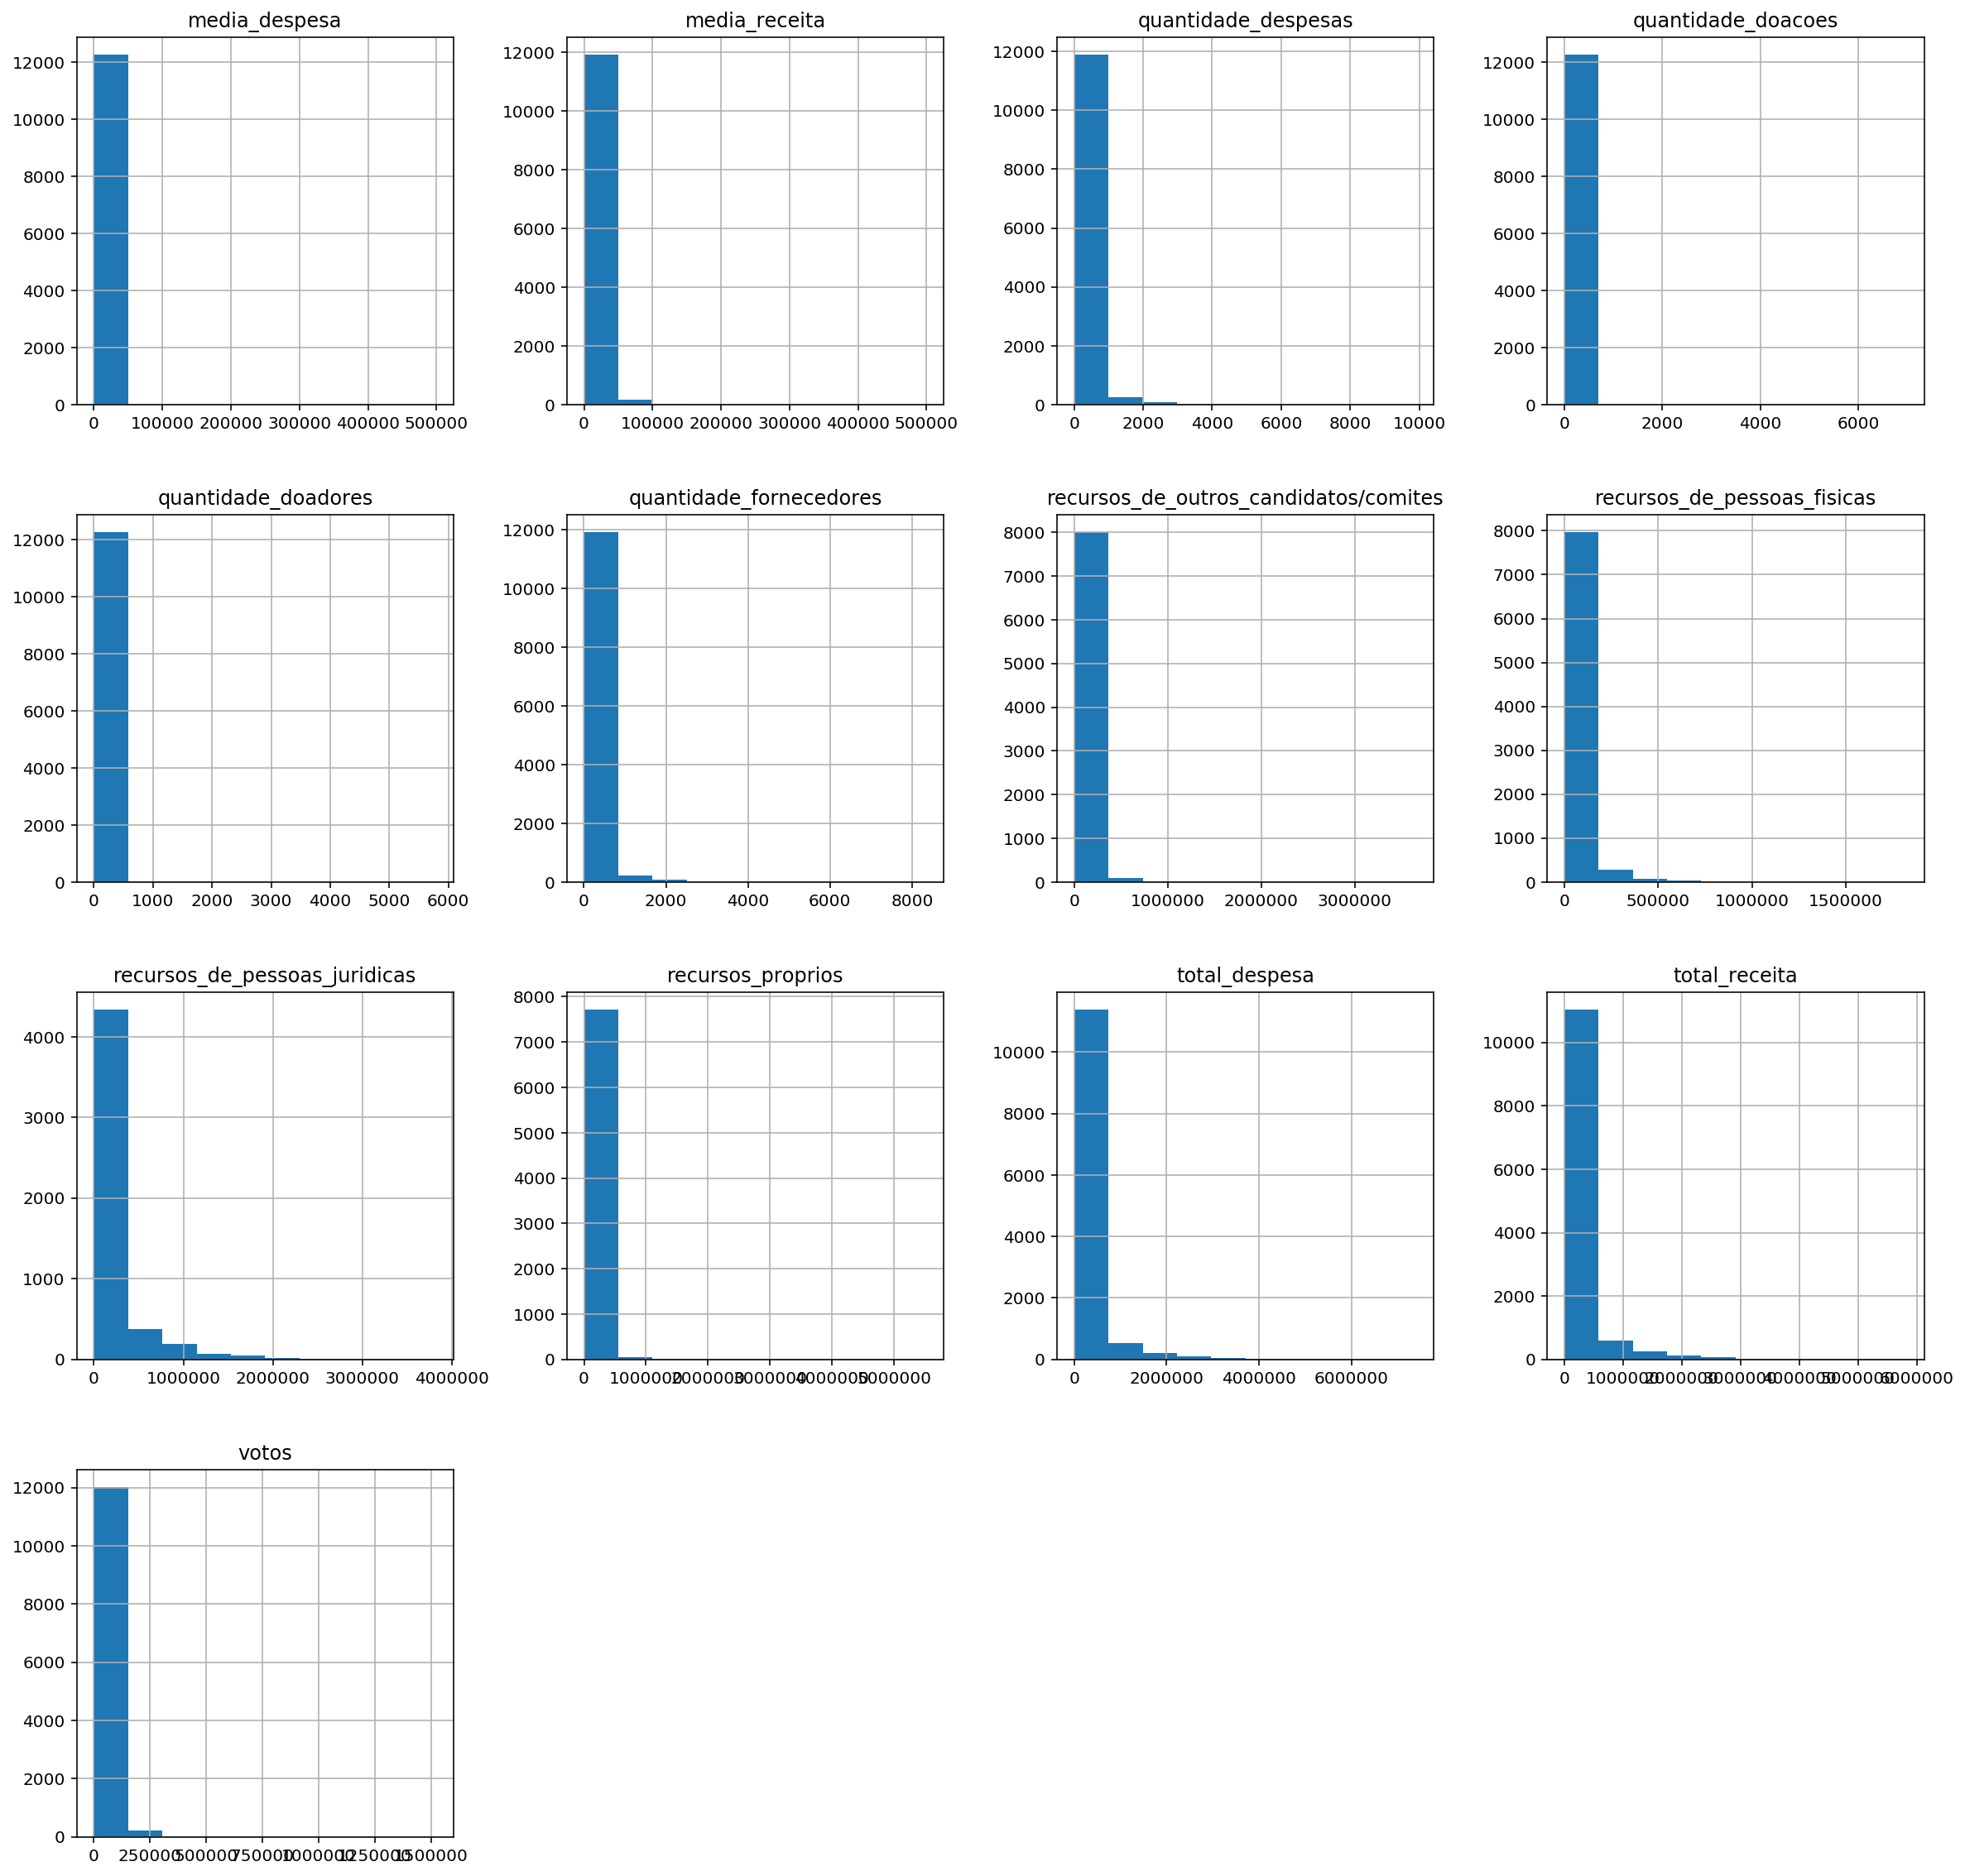

In [27]:
### Verificando a distribuição dos dados
df[df.dtypes[df.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

Verificamos através da visualização acima que as variáveis numéricas estão completamente enviesadas à esquerda.
Medidas como correlação ou regressão podem ser bastante influenciadas pelo pico da distribuição, outliers, dentre outros. 
Visando reduzir o efeito do viés nesses atributos aplicaremos uma transformação utilizando uma função logarítmica.

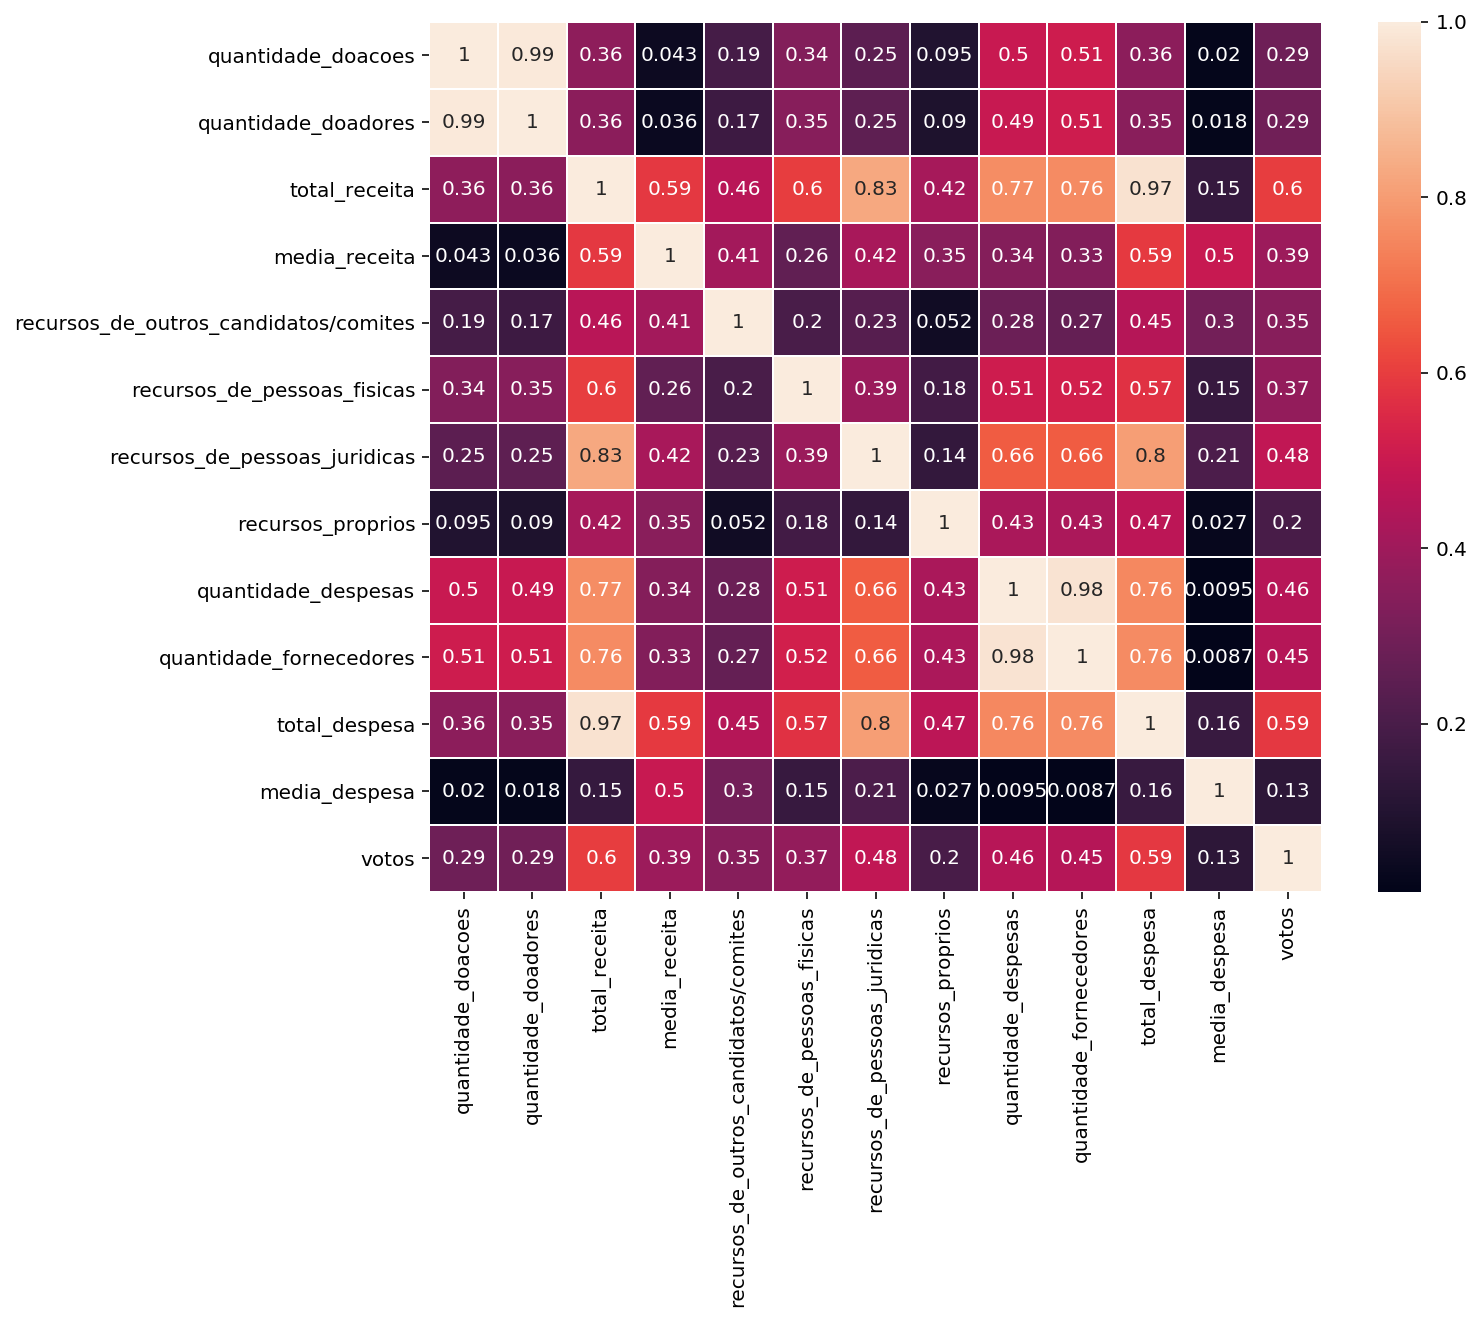

In [28]:
## Correlações entre os atributos numéricos antes das transformações
# Visualização
fig = plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2g', linewidths=.5)
plt.show()

Podemos perceber, através da matriz de correlação acima, que a variável alvo (`votos`) está fracamente correlacionada com a maioria dos atributos preditores.

### Transformações

In [29]:
# Transformando a variável alvo com a função "log"
y = np.log1p(y)

# Transformando os atributos numéricos com a função "log"
## Separando os atributos numéricos
atributos_num = X.dtypes[X.dtypes != "object"].index
## Criando variáveis para os atributos categóricos
atributos_env = X[atributos_num].apply(lambda x: skew(x.dropna())) #compute skewness
atributos_env = atributos_env.index
## Transformando os atributos com a função "log"
X[atributos_env] = np.log1p(X[atributos_env])

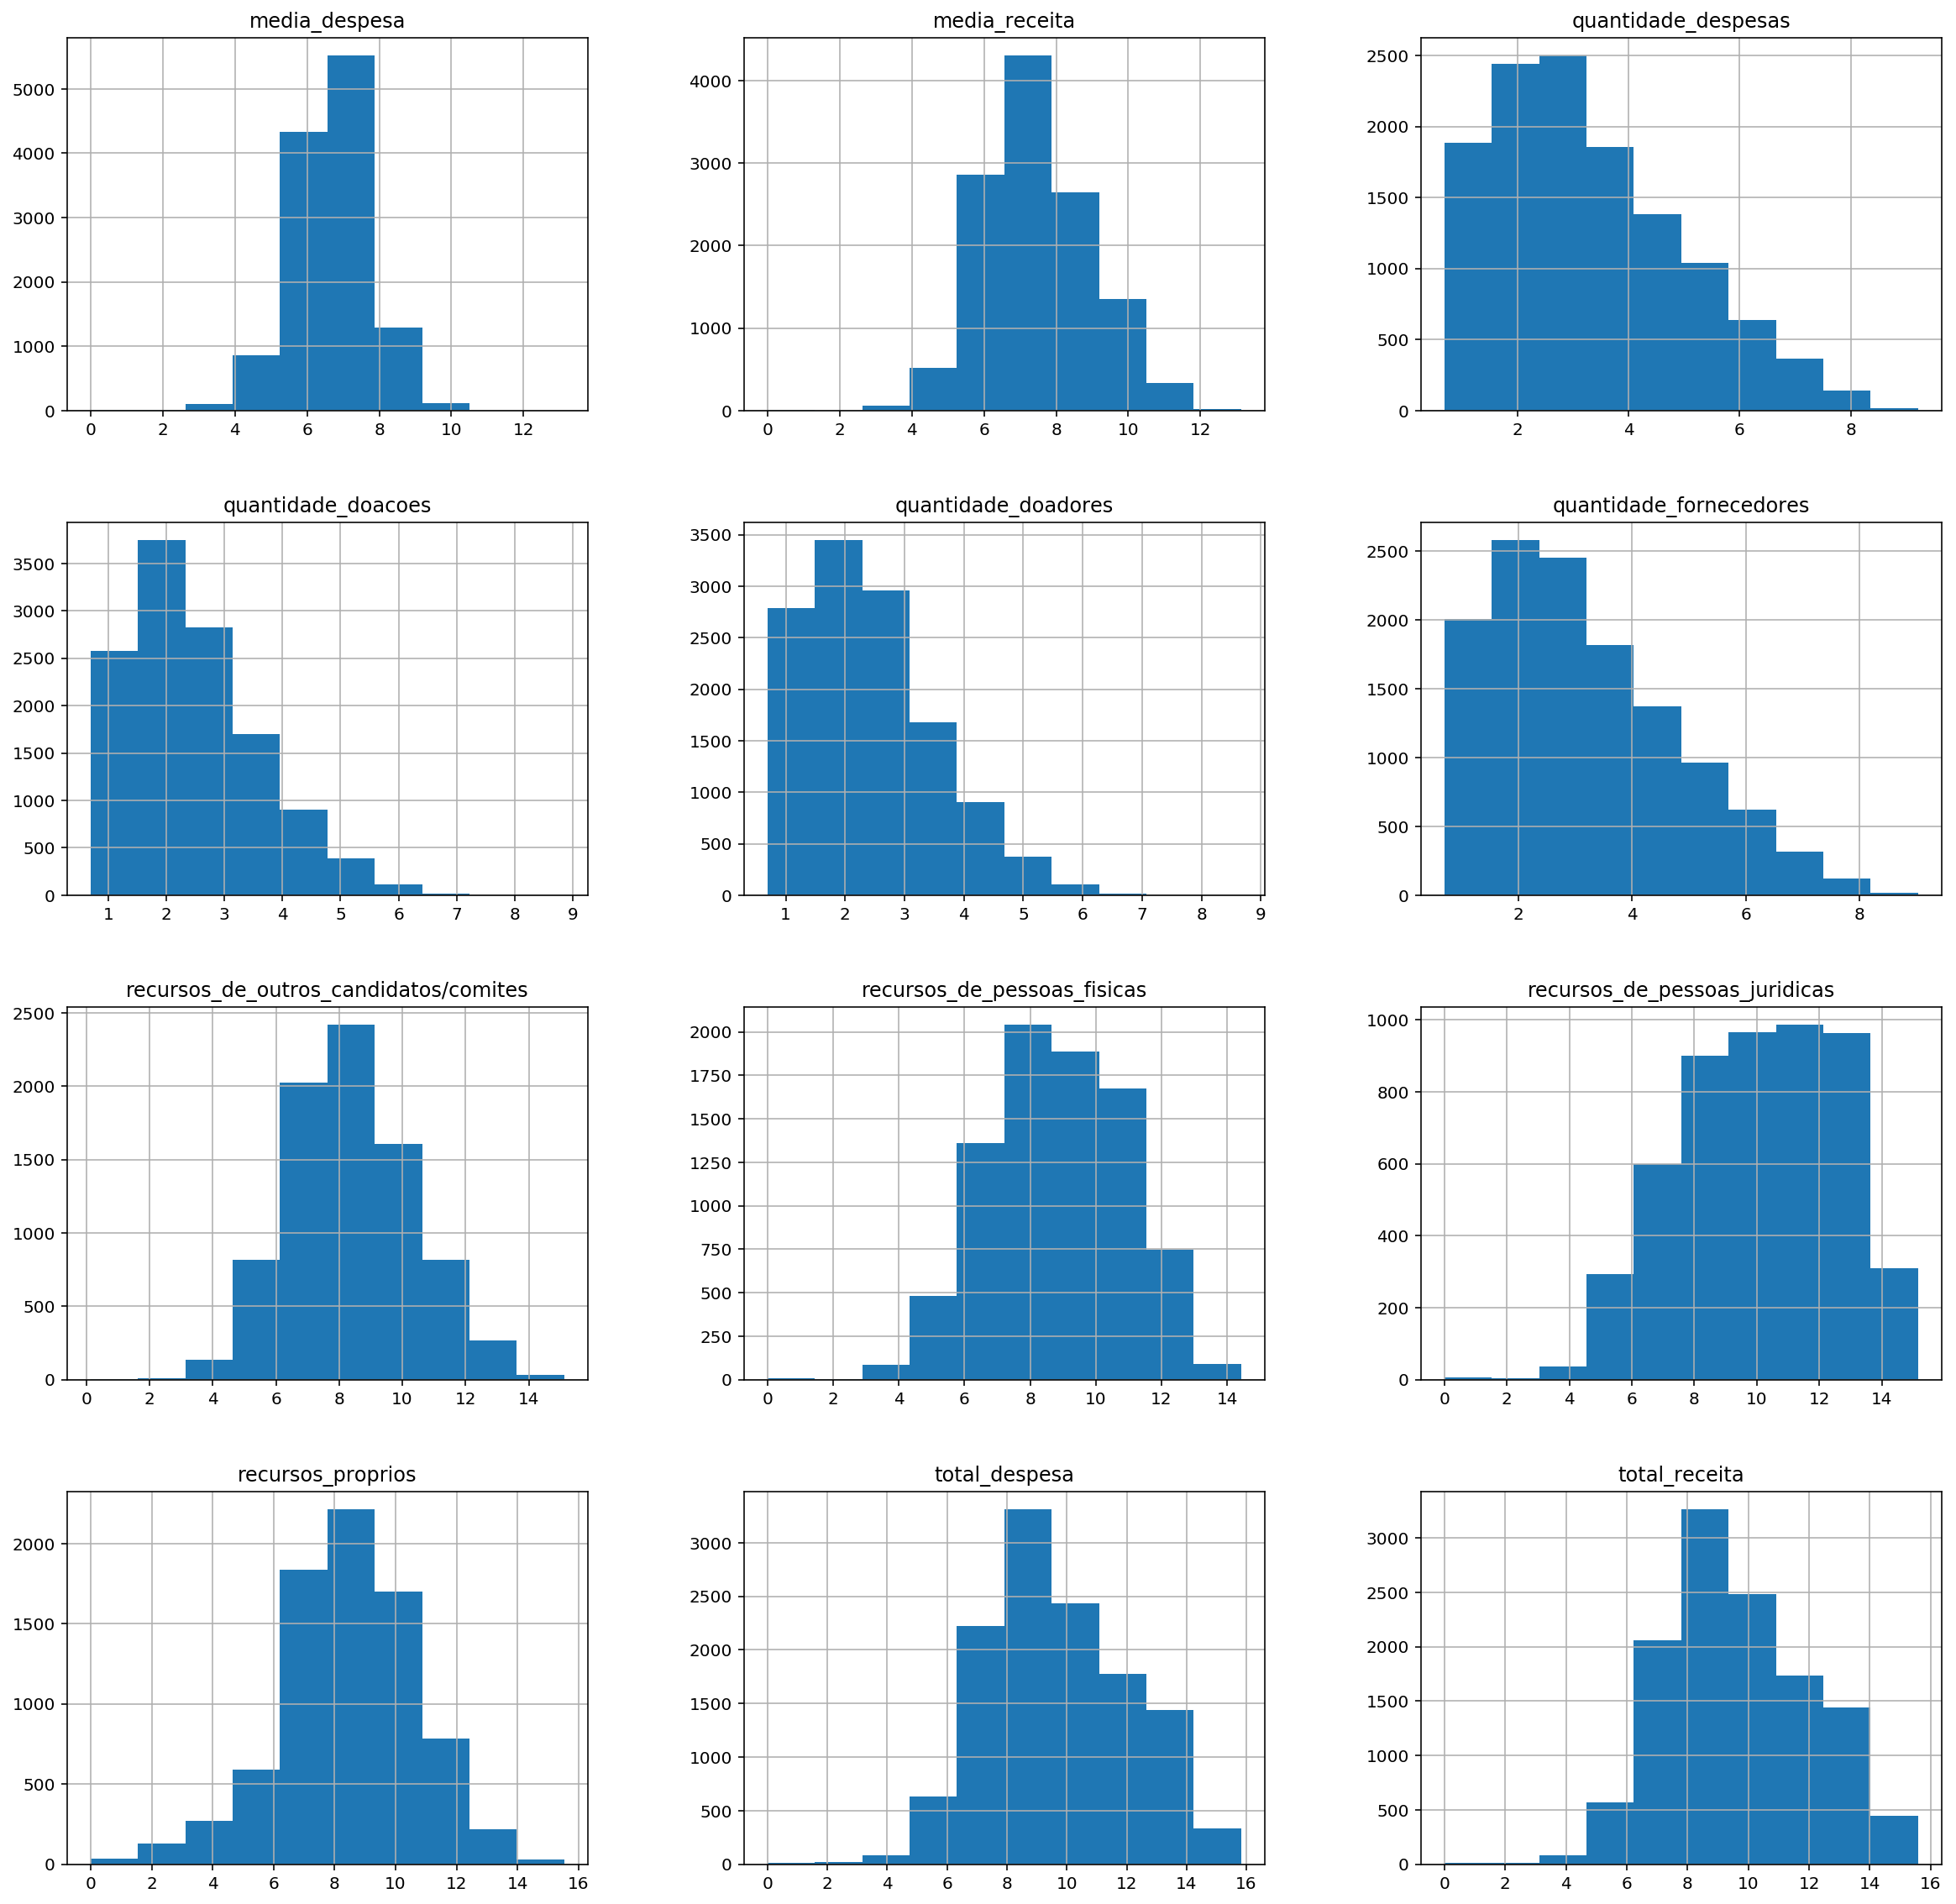

In [30]:
### Distribuição dos dados após transformações
X[X.dtypes[X.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

Verificamos que com a aplicação da função logarítmica a maior parte dos atributos estão menos enviesados, no entanto alguns desses atributos ainda apresentam algun enviesamento, como é o caso das `quantidades de despesas, doações, doadores e fornecedores`.

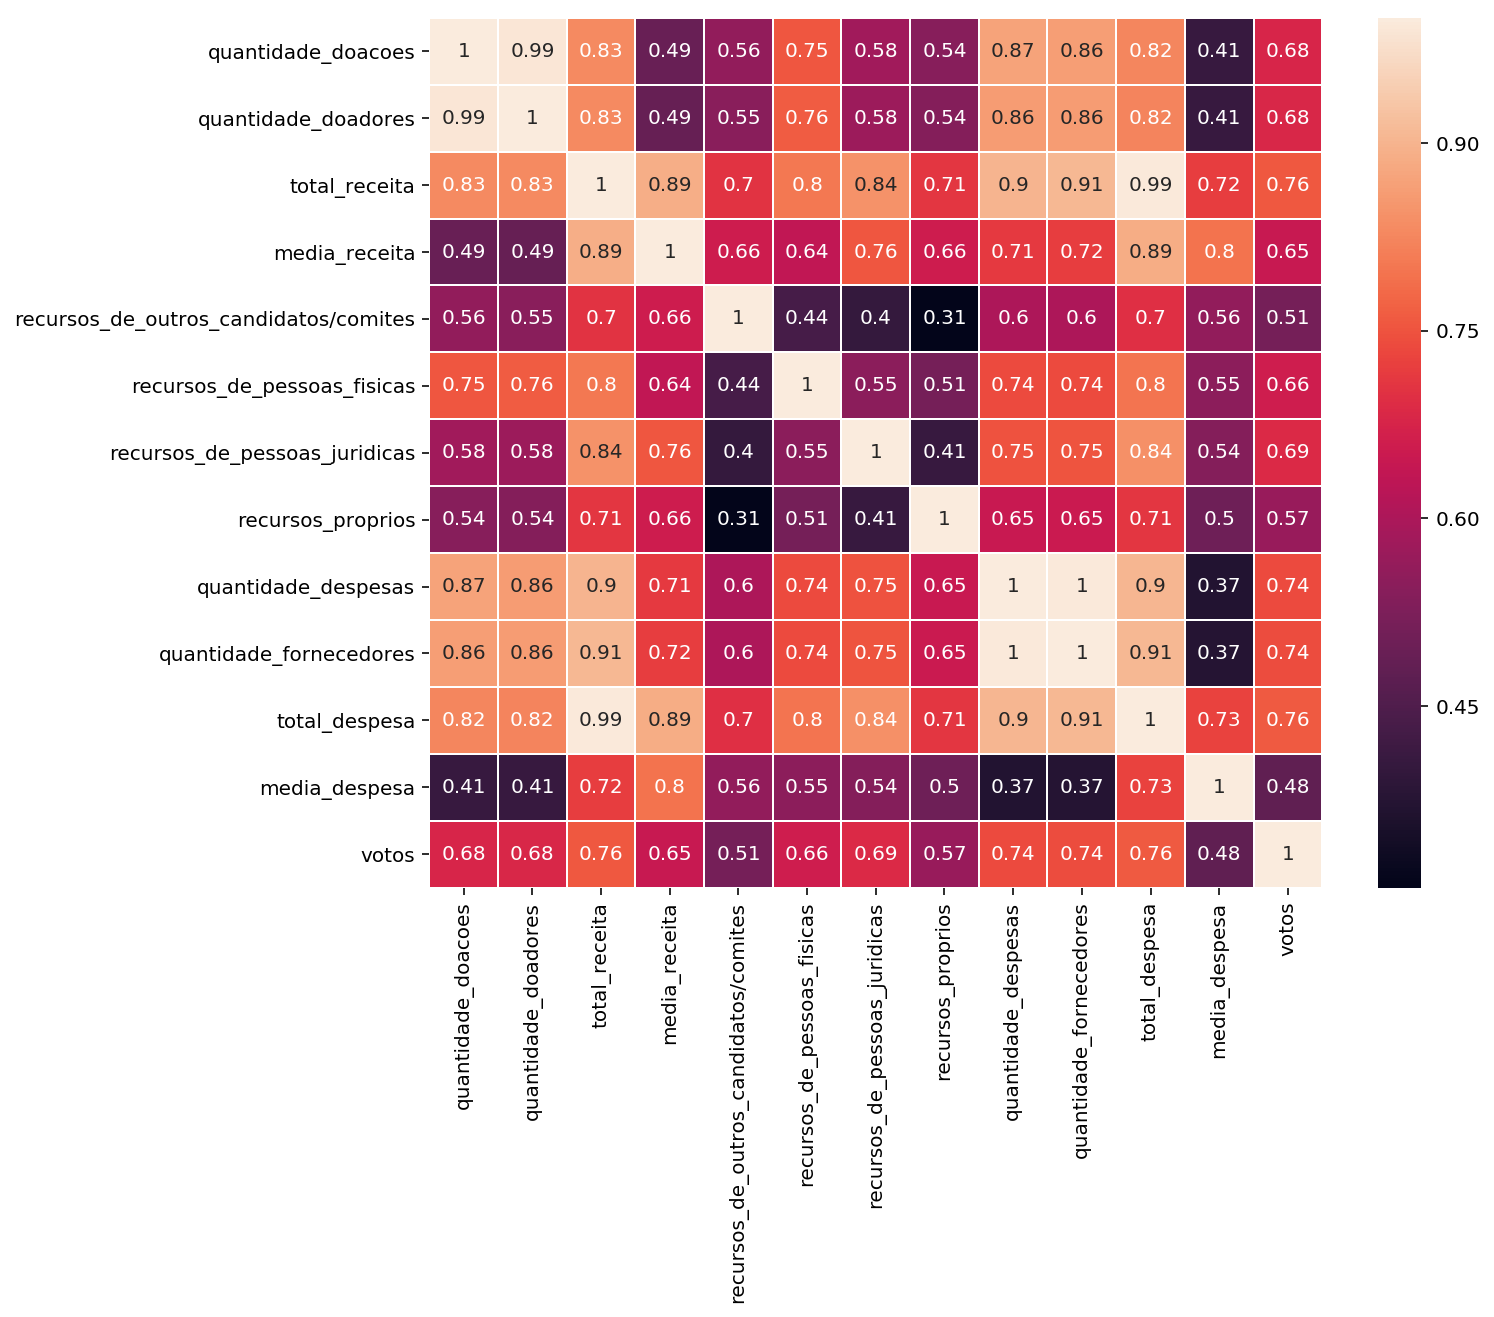

In [31]:
### Correlação entre os atributos numéricos após as transformações
# Concatenando o dataset
df_temp = pd.concat((train,test))
# Transformando os atributos numéricos com a função "log"
## Separando os atributos numéricos
atb_num = df_temp.dtypes[df_temp.dtypes != "object"].index
## Criando variáveis para os atributos categóricos
atb_env = df_temp[atb_num].apply(lambda x: skew(x.dropna())) #compute skewness
atb_env = atb_env.index
## Transformando os atributos com a função "log"
df_temp[atb_env] = np.log1p(df_temp[atb_env])
# Visualização
fig = plt.figure(figsize=(10,8))
sns.heatmap(df_temp.corr(), annot=True, fmt='.2g', linewidths=.5)
plt.show()

Após as transformações verificamos que as correlações entre os atributos numéricos e a variável alvo (votos) aumentaram consideravelmente.
Entretanto, é necessário ter cuidado ao avaliar as correlações. Alguns dados podem indicar uma correlação que não existe de fato, e é apenas obra do acaso, o que é possível em certos casos onde variáveis apresentam algum tipo de padrão que pode levar a este valor de correlação, sendo necessária uma avaliação criteriosa dos dados.

In [32]:
# Converter variáveis categóricas em variáveis indicadoras
X = pd.get_dummies(X)

In [33]:
# Preenchendo os valores faltantes com zero
X = X.fillna(0)

### Dividindo os dados em treino e teste

#### Utilizando sklearn.model_selection para a divisão dos dados em treino e teste

Dividir os dados de 2006 para treino e 2010 para teste não se mostrou uma abordagem eficiente, por esse motivo, os dados de treino e teste foram divididos considerando-se 60% para treino e 40% para testes

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

### Métricas de avaliação dos modelos

É difícil medir a qualidade de um modelo sem quantificar seu desempenho durante o treinamento e teste. Isso é geralmente feito utilizando algum tipo de métrica de desempenho, através do cálculo de algum tipo de erro, qualidade de ajuste, ou qualquer outra medida útil. Para este projeto, ultilizaremos como métricas de avaliação dos modelos o Root Mean Square Error (**RMSE**) e o Coeficiente de Determinação (**$R^2$**)

**Root Mean Square Error** (raiz do erro quadrático médio) (RMSE) é a raiz quadrada da média dos erros quadrados:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


O RMSE é a raiz quadrada da variância dos resíduos. Indica o ajuste absoluto do modelo aos dados - quão próximos os pontos de dados observados estão dos valores previstos do modelo. Enquanto o R-quadrado é uma medida relativa de ajuste, o RMSE é uma medida absoluta de ajuste. Como a raiz quadrada de uma variância, o RMSE pode ser interpretado como o desvio padrão da variância inexplicada e tem a propriedade útil de estar nas mesmas unidades que a variável de resposta. Valores mais baixos de RMSE indicam melhor ajuste. O RMSE é uma boa medida da precisão com que o modelo prediz a resposta e é o critério mais importante para o ajuste se a finalidade principal do modelo for a previsão.

**Coeficiente de Determinação ($R^2$)**

Uma das formas de avaliar a qualidade do ajuste do modelo é através do coeficiente de determinação. Basicamente, este coeficiente indica quanto o modelo foi capaz de explicar os dados coletados. O coeficiente de determinação é dado pela expressão:

$$R^2=\frac{SSR}{SSTO}=1-\frac{SSE}{SSTO}$$, onde:

$$SSR=\sum_{i=1}^{n}(\hat{y}_i-\bar{y})^2$$

$$SSE=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

$$SSTO=\sum_{i=1}^{n}(y_i-\bar{y})^2$$


Os valores para $R^2$ variam entre 0 a 1. Esses valores indicam a porcentagem da correlação ao quadrado entre a estimativa e o valor atual da variável alvo. Um modelo $R^2$ de valor 0 sempre falha ao estimar a variável alvo, enquanto que um modelo R2 de valor 1, estima perfeitamente a variável alvo. Qualquer valor entre 0 e 1 indica qual a porcentagem da variável alvo (ao utilizar o modelo) que pode ser explicada pelos atributos. Um modelo pode dar também um $R^2$ negativo, que indica que o modelo não é melhor do que aquele que estima ingenuamente a média da variável alvo.

Existem situações em que um $R^2$ alto não é necessário ou relevante. Quando o interesse está na relação entre variáveis, não na previsão, o $R^2$ é menos importante.

O $R^2$ é escalonado convenientemente entre 0 e 1, enquanto o RMSE não é escalado para nenhum valor particular. Isso pode ser bom ou ruim; obviamente, o $R^2$ pode ser mais facilmente interpretado, mas com o RMSE explicitamente sabemos o quanto nossas previsões se desviam, em média, dos valores reais no conjunto de dados. Então, de certa forma, o RMSE diz mais.

## Modelos

### Regressão Linear sem regularização

In [36]:
# Iportando as bibliotecas necessárias
from sklearn.linear_model import LinearRegression

In [37]:
# Parametrizando o modelo
lm = LinearRegression()

In [38]:
# Ajustando o modelo
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
# Predição de instancias 
lm_predict = lm.predict(X_test)

In [40]:
# Printando a intercepção
print(lm.intercept_)

137363418600.04803


In [41]:
# Printando os coeficientes
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df.head(10)

,Coefficient
quantidade_doacoes,0.000919
quantidade_doadores,0.706236
total_receita,-0.386425
media_receita,0.562219
recursos_de_outros_candidatos/comites,0.012928
recursos_de_pessoas_fisicas,0.031533
recursos_de_pessoas_juridicas,0.054286
recursos_proprios,0.025647
quantidade_despesas,-0.007904
quantidade_fornecedores,1.117568


#### Metricas de avaliação do modelo

In [42]:
# Computando o RMSE (Root Mean Square Error)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm_predict)))

RMSE: 1.3465640063964137


In [43]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, lm_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.6514642936965801


#### Visualizações

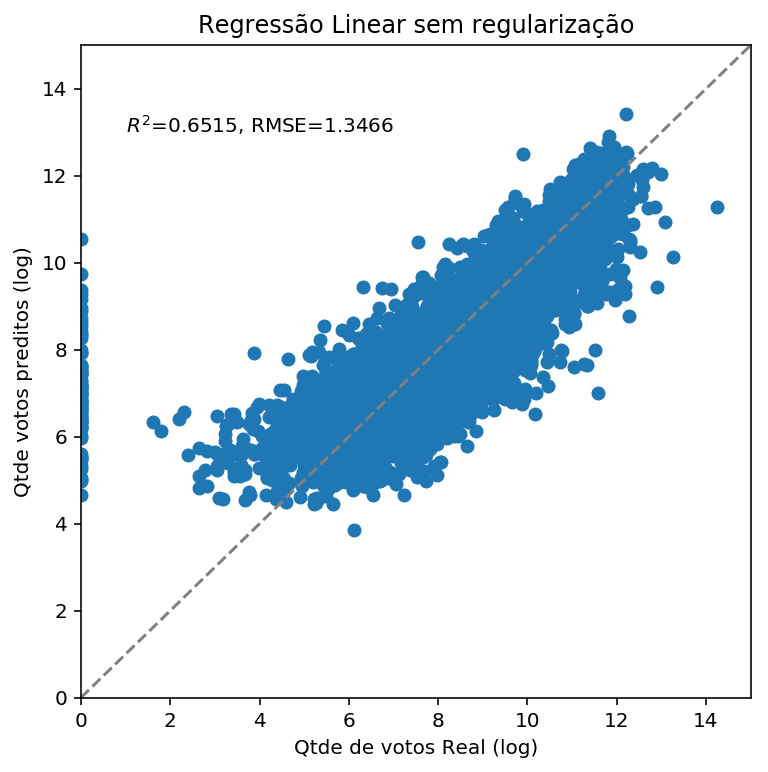

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lm_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear sem regularização')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, lm_predict), np.sqrt(metrics.mean_squared_error(y_test, lm_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

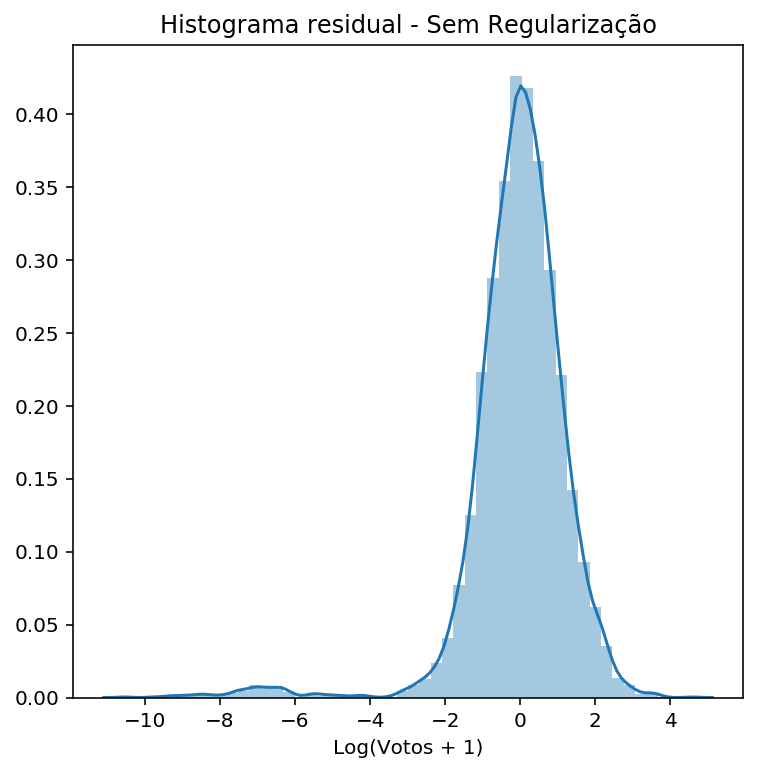

In [45]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - lm_predict),bins=50)
ax.set_title('Histograma residual - Sem Regularização')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Regressão linear com regularização Ridge

In [46]:
# Iportando as bibliotecas necessárias
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

O principal parâmetro de ajuste para o modelo Ridge é alpha - um parâmetro de regularização que mede quão flexível é nosso modelo. Quanto maior a regularização, menos propenso será o nosso modelo de overfit. No entanto, também perderá a flexibilidade e poderá não capturar todo o sinal nos dados.

In [47]:
### Verificando o melhor alpha
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

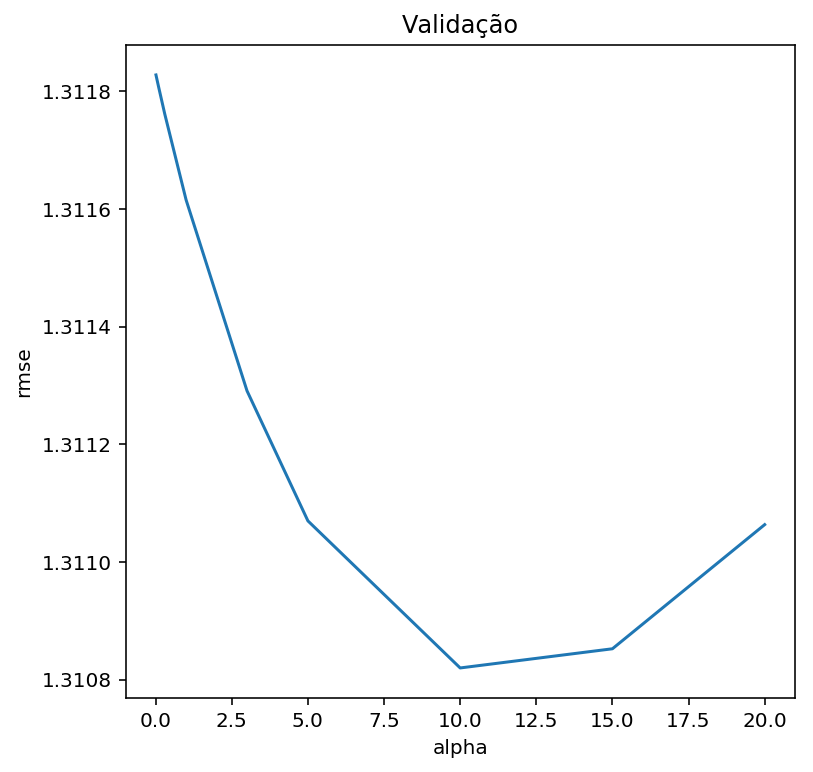

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Observe a curva em forma de U acima. Quando alfa é muito grande, a regularização é muito forte e o modelo não consegue capturar todas as complexidades dos dados. Se, no entanto, deixarmos o modelo ser muito flexível (alfa pequeno), o modelo começa a se sobrepor. Um valor de alfa = 5 é quase certo com base no gráfico acima.

In [49]:
# Parametrizando o modelo levando em consideração um alpha que leva a um menor RMSE
model_ridge = Ridge(alpha=10)

In [50]:
# Ajustando o modelo
model_ridge.fit(X_train,y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [51]:
# Predição do modelo
ridge_predict = model_ridge.predict(X_test)

##### Metricas de avaliação do modelo

In [52]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_predict)))

RMSE: 1.3465316812337333


In [53]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, ridge_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.6514810271576306


#### Coeficientes

In [54]:
# Printando a intercepção
print(model_ridge.intercept_)

2.396415050068631


In [55]:
# Coeficente da regressão com regularização ridge
coef_ridge = pd.DataFrame(model_ridge.coef_,X_train.columns,columns=['Coefficient'])
coef_ridge.head(10)

,Coefficient
quantidade_doacoes,0.013502
quantidade_doadores,0.676956
total_receita,-0.383486
media_receita,0.554704
recursos_de_outros_candidatos/comites,0.012861
recursos_de_pessoas_fisicas,0.031650
recursos_de_pessoas_juridicas,0.056977
recursos_proprios,0.025304
quantidade_despesas,0.034316
quantidade_fornecedores,0.831330


#### Visualizações

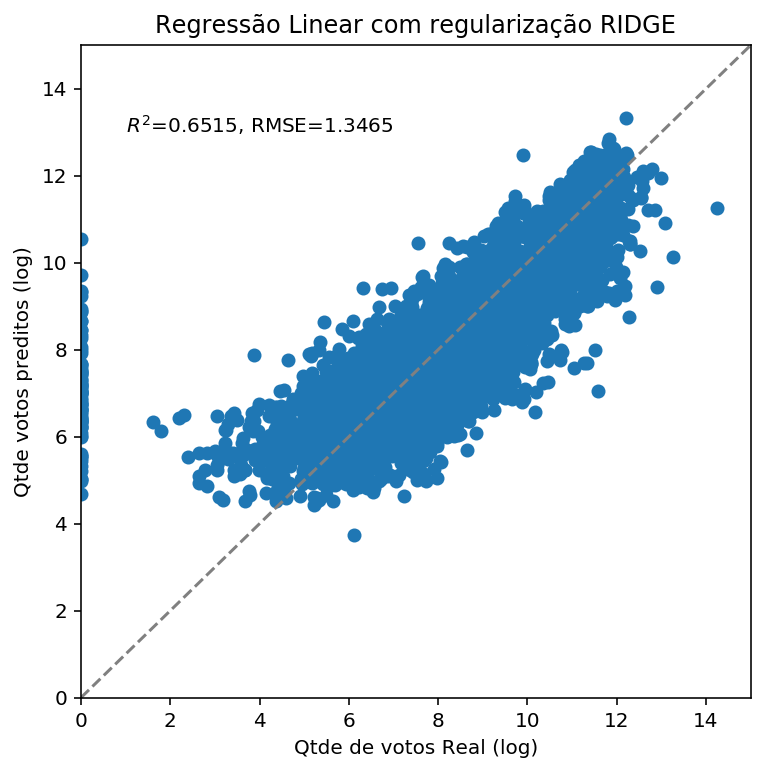

In [56]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, ridge_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear com regularização RIDGE')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, ridge_predict), np.sqrt(metrics.mean_squared_error(y_test, ridge_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

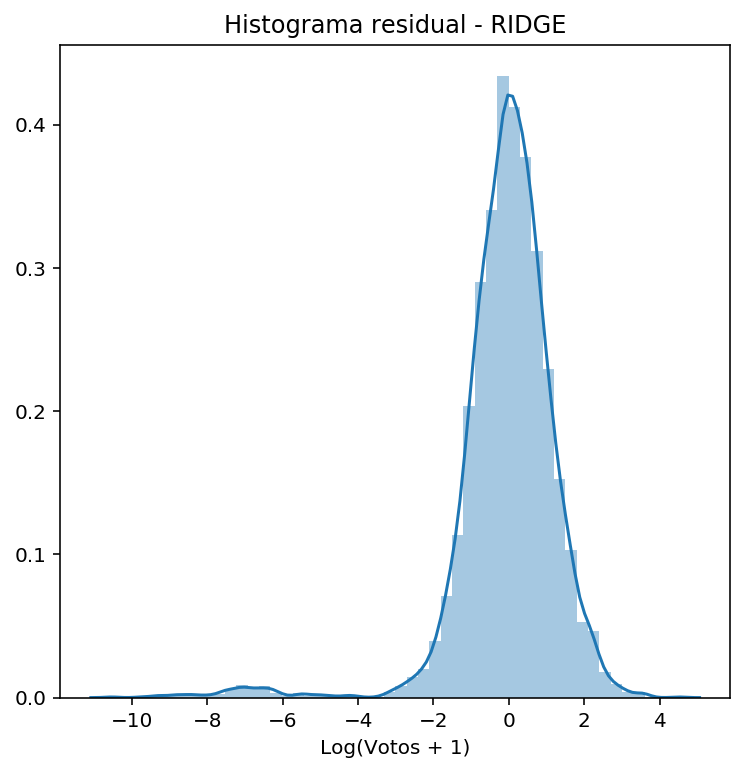

In [57]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - ridge_predict),bins=50)
ax.set_title('Histograma residual - RIDGE')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

## Regressão linear com regularização Lasso

In [58]:
warnings.filterwarnings('ignore')
# Parametrizando o modelo
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [59]:
# Predição do modelo
lasso_predict = model_lasso.predict(X_test)

#### Metricas de avaliação do modelo

In [60]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_predict)))

RMSE: 1.3483630039934722


In [61]:
# Coeficiente de determinação (R²)
print('R²:',metrics.r2_score(y_test, lasso_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.6505323903658415


#### Coeficientes

In [62]:
# Printando a intercepção
print(model_lasso.intercept_)

2.6807000443971774


In [63]:
# Coeficientes da regressão com regularização lasso
coef_lasso = pd.DataFrame(model_lasso.coef_, index = X_train.columns, columns=['Coefficient'])
coef_lasso.head(10)

,Coefficient
quantidade_doacoes,0.000000
quantidade_doadores,0.699261
total_receita,-0.394195
media_receita,0.569137
recursos_de_outros_candidatos/comites,0.012981
recursos_de_pessoas_fisicas,0.031545
recursos_de_pessoas_juridicas,0.057771
recursos_proprios,0.025302
quantidade_despesas,0.011060
quantidade_fornecedores,0.755976


In [64]:
# Coeficientes da regressão com regularização lasso
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

Verificando os coeficientes selecionados pelo LASSO

In [65]:
print("O Lasso selecionou " + str(sum(coef_lasso != 0)) + " variaveis e eliminou outras " +  \
      str(sum(coef_lasso == 0)) + " variaveis")

O Lasso selecionou 75 variaveis e eliminou outras 14 variaveis


Visualizando os 10 coeficientes mais/menos importantes

In [66]:
# Selecionando os 10 primeiros e os 10 últimos coeficientes
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])

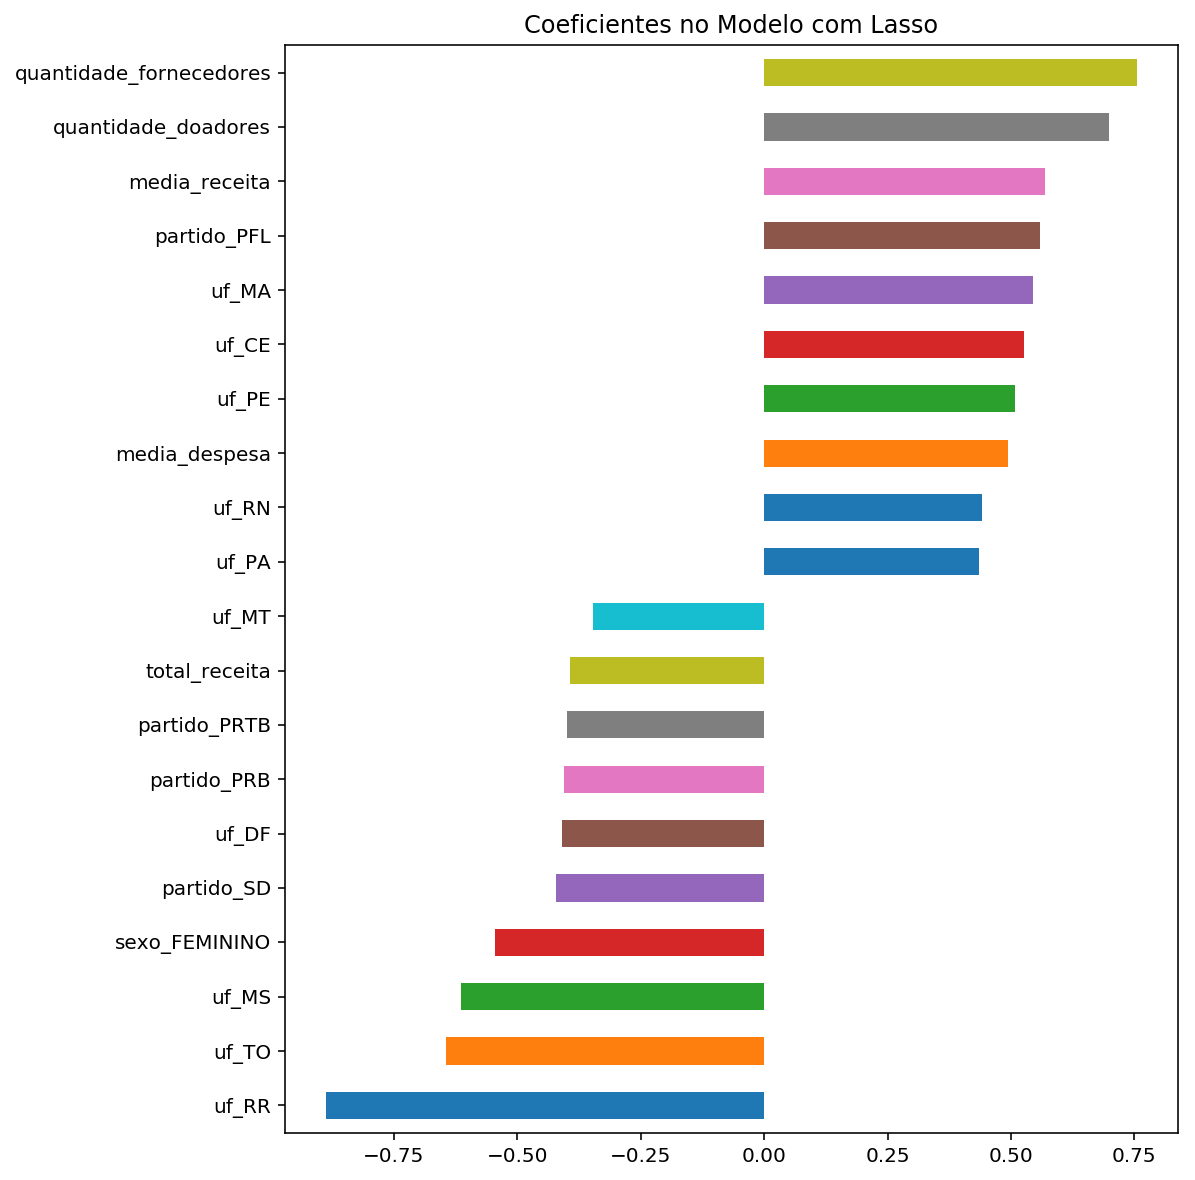

In [67]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coeficientes no Modelo com Lasso")
plt.show()

Podemos perceber pela visualização acima que o atributo mais importante é `quantidade_fornecedores`.

#### Visualizações

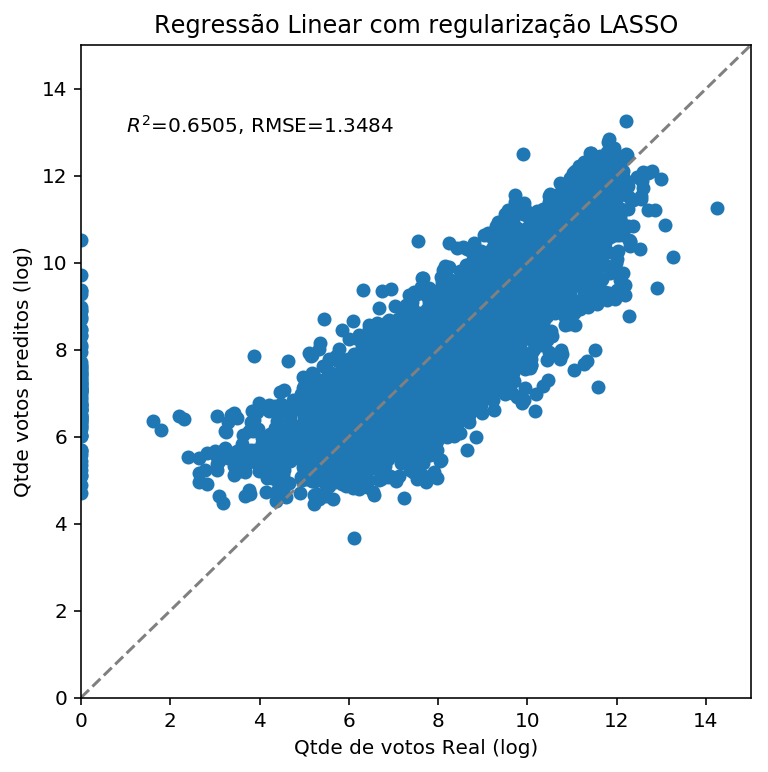

In [68]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lasso_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear com regularização LASSO')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, lasso_predict), np.sqrt(metrics.mean_squared_error(y_test, lasso_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

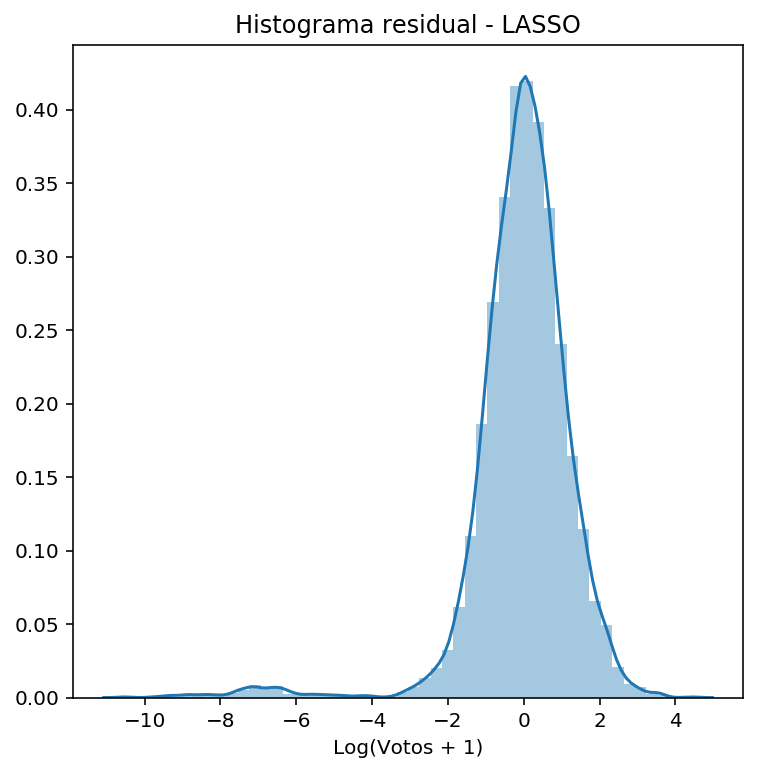

In [69]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - lasso_predict),bins=50)
ax.set_title('Histograma residual - LASSO')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Comparando os modelos de regressão avalidados

Nessa comparação os RMSEs são apresentados em quatidade de votos. Para isso reverteu-se a transformação feita na variável alvo antes de calcular o RMSE.

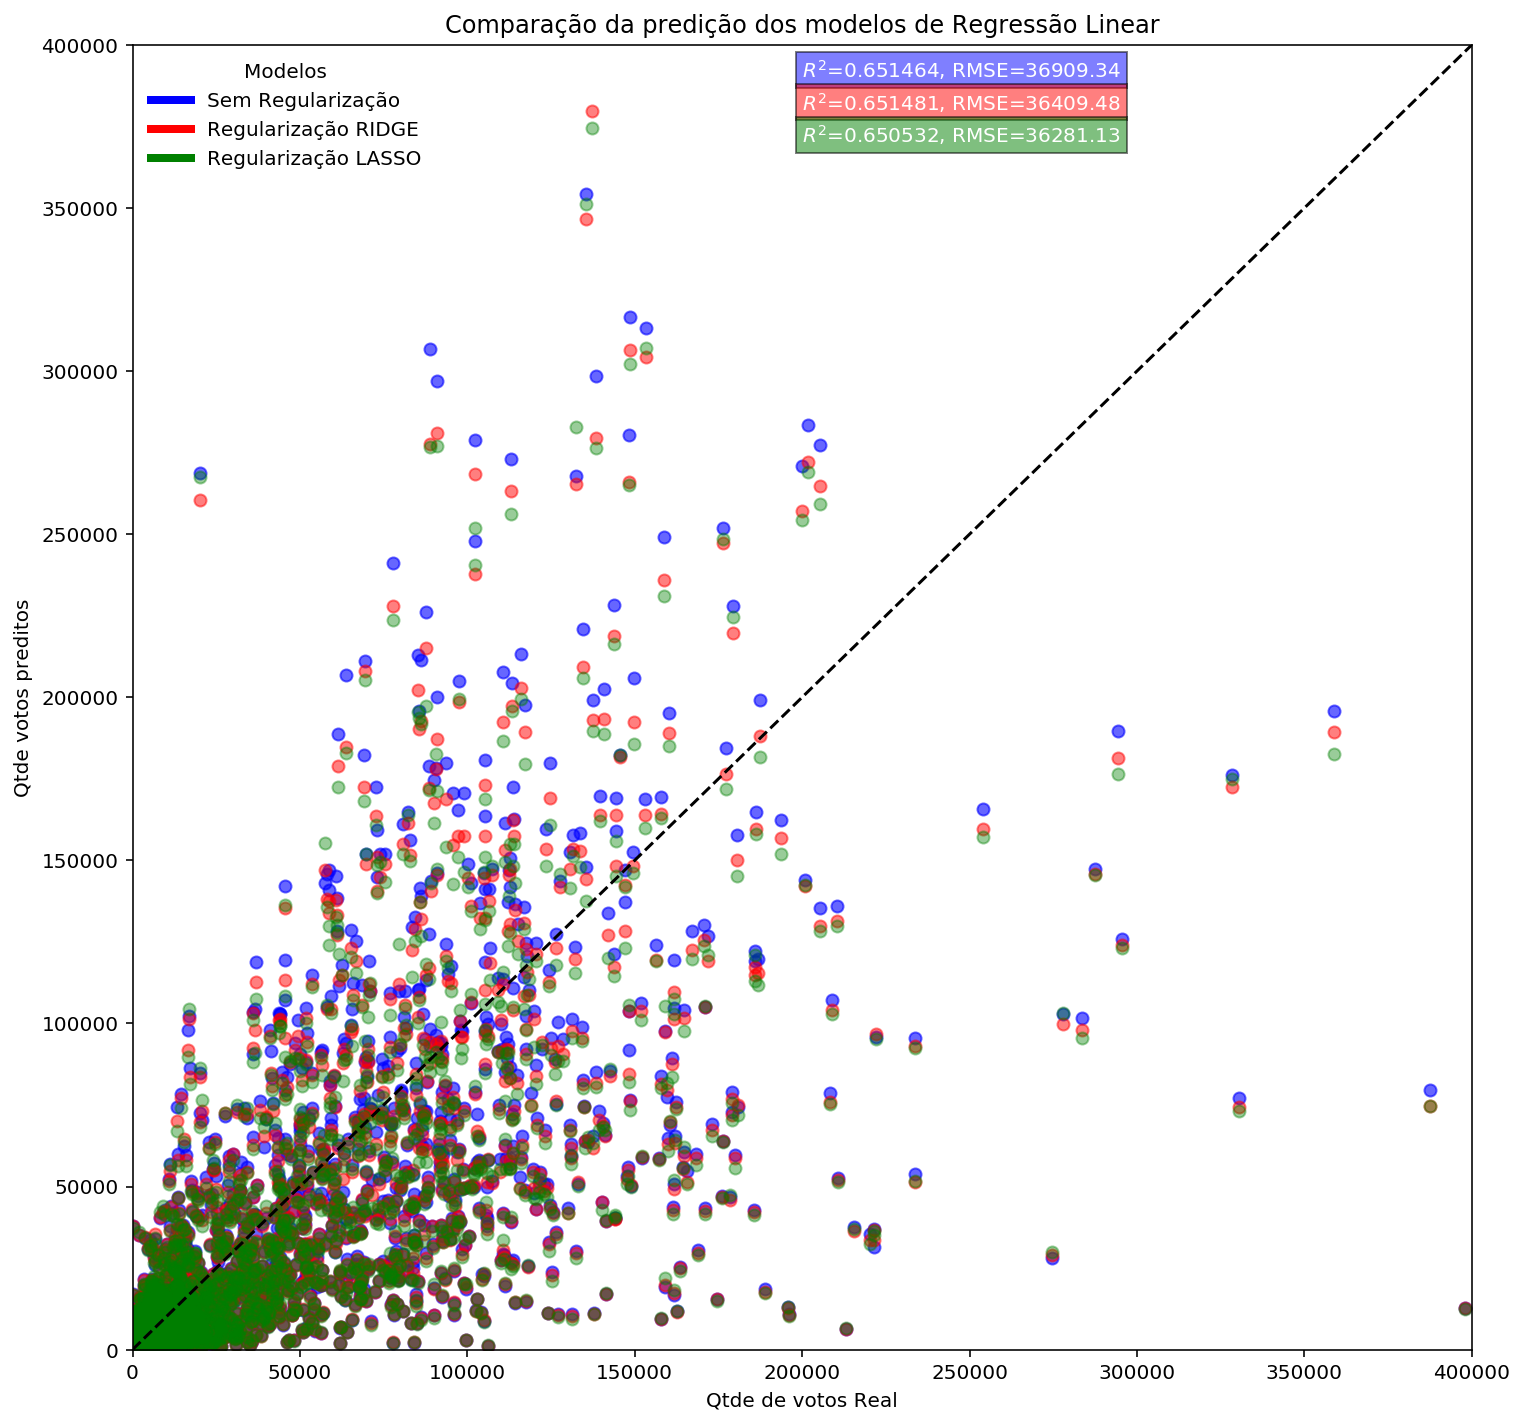

In [70]:
# Gráfico de dispersão comparando os modelos de regressão linear
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(np.expm1(y_test), np.expm1(lm_predict), c='b', alpha=0.6)
ax.scatter(np.expm1(y_test), np.expm1(ridge_predict), c='r', alpha=0.5)
ax.scatter(np.expm1(y_test), np.expm1(lasso_predict), c='g', alpha=0.4)
ax.plot([0, 400000], [0, 400000], '--k')
ax.set_ylabel('Qtde votos preditos')
ax.set_xlabel('Qtde de votos Real')
ax.set_title('Comparação da predição dos modelos de Regressão Linear')
ax.text(200000, 390000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, lm_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(lm_predict)))), bbox={'facecolor': 'b', 'alpha': 0.5, 'pad': 3}, color='w')
ax.text(200000, 380000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, ridge_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(ridge_predict)))), bbox={'facecolor': 'r', 'alpha': 0.5, 'pad': 3}, color='w')
ax.text(200000, 370000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, lasso_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(lasso_predict)))), bbox={'facecolor': 'g', 'alpha': 0.5, 'pad': 3}, color='w')
ax.set_xlim([0, 400000])
ax.set_ylim([0, 400000])
# Legendas
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ["Sem Regularização","Regularização RIDGE", "Regularização LASSO"], \
           title="Modelos", frameon=False, loc='upper left')
plt.show()

Pela visualização acima verificamos que as regresões lineares tiveram um desempenho parecido com $R^2$ um pouco maior para a Regressão linear com regularização LASSO e $RMSE$ menor para a Regressão Linear com regularização RIDGE.

###  KNN Regressor

In [71]:
# Iportando as bibliotecas necessárias
from sklearn.neighbors import KNeighborsRegressor

In [72]:
# Parametrizando o modelo
knn = KNeighborsRegressor(n_neighbors=8,weights='uniform',p=2)

In [73]:
# Ajustando o modelo
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')

In [74]:
# Predição do modelo
knn_predict = knn.predict(X_test)

#### Metricas de avaliação do modelo

In [75]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, knn_predict)))

RMSE: 1.4128770771693087


In [76]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, knn_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.61629095947635


#### Visualizações

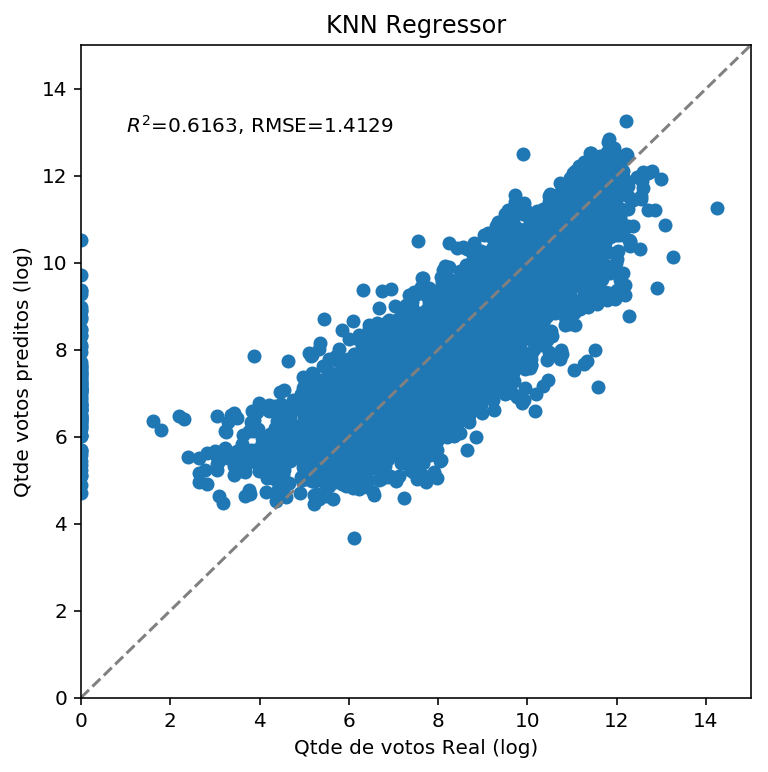

In [77]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lasso_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('KNN Regressor')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, knn_predict), np.sqrt(metrics.mean_squared_error(y_test, knn_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

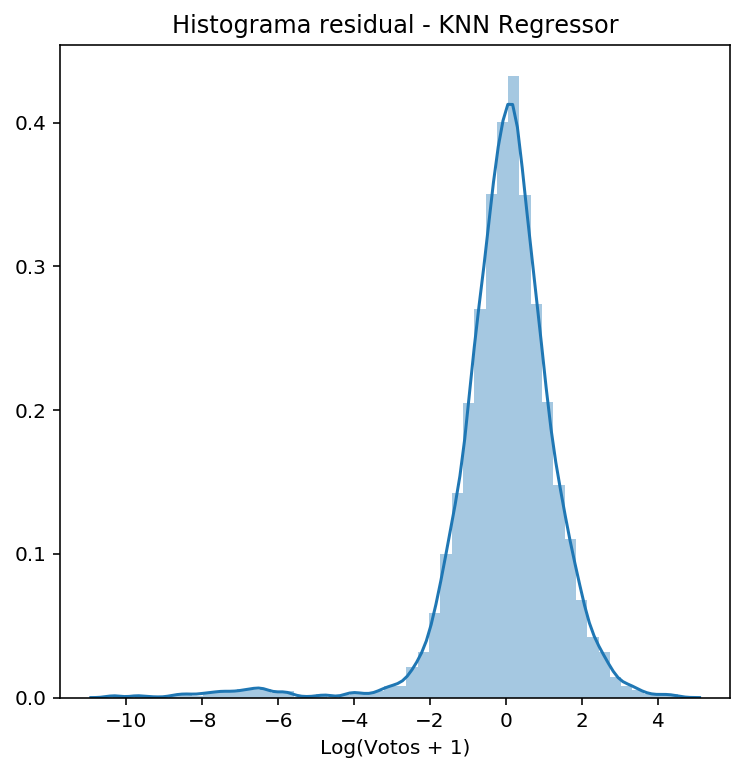

In [78]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - knn_predict),bins=50)
ax.set_title('Histograma residual - KNN Regressor')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Random Forest Regression

In [79]:
# Iportando as bibliotecas necessárias
from sklearn.ensemble import RandomForestRegressor

In [80]:
# Parametrizando o modelo
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [81]:
# Ajustando o modelo
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
# Predição do modelo
rfr_predict = rfr.predict(X_test)

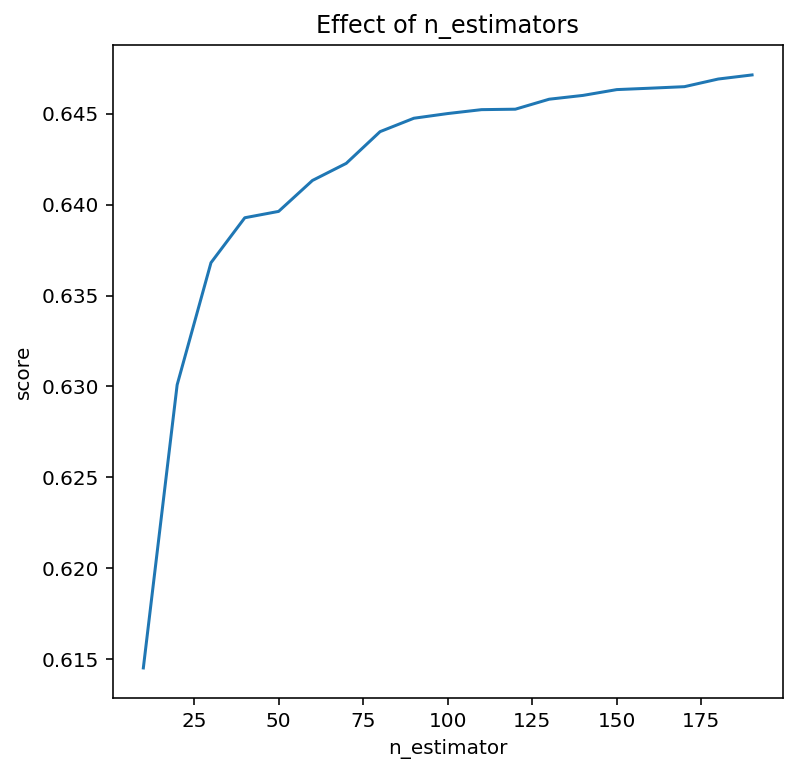

In [83]:
# Verificando números diferentes de n_estimators
fig, ax = plt.subplots(figsize=(6, 6))

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rfr.set_params(n_estimators=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
plt.show()

#### Metricas de avaliação do modelo

In [84]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_predict)))

RMSE: 1.3589637813726696


In [85]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, rfr_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.6450157881723313


#### Vizualizações

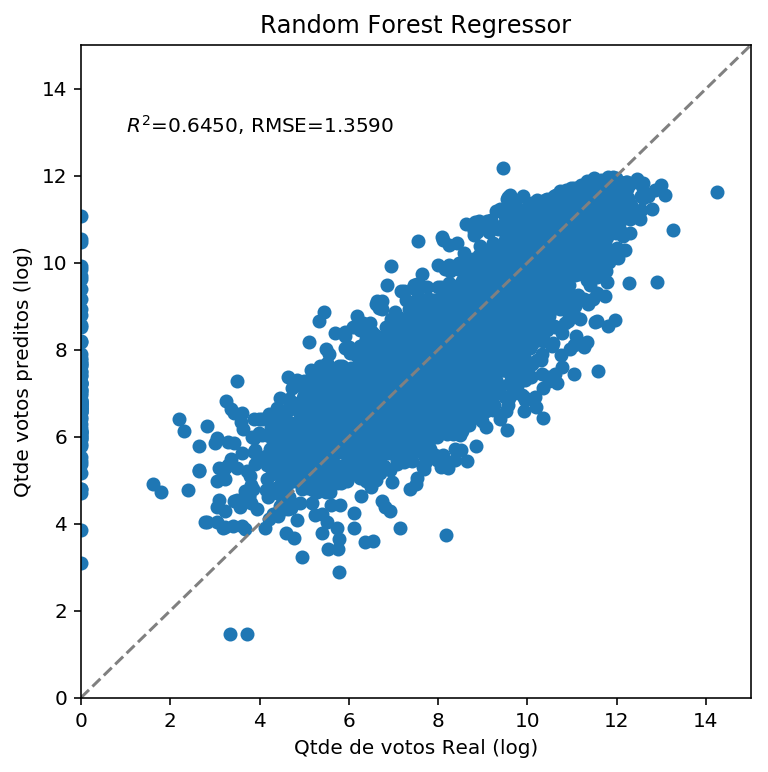

In [86]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, rfr_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Random Forest Regressor')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, rfr_predict), np.sqrt(metrics.mean_squared_error(y_test, rfr_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

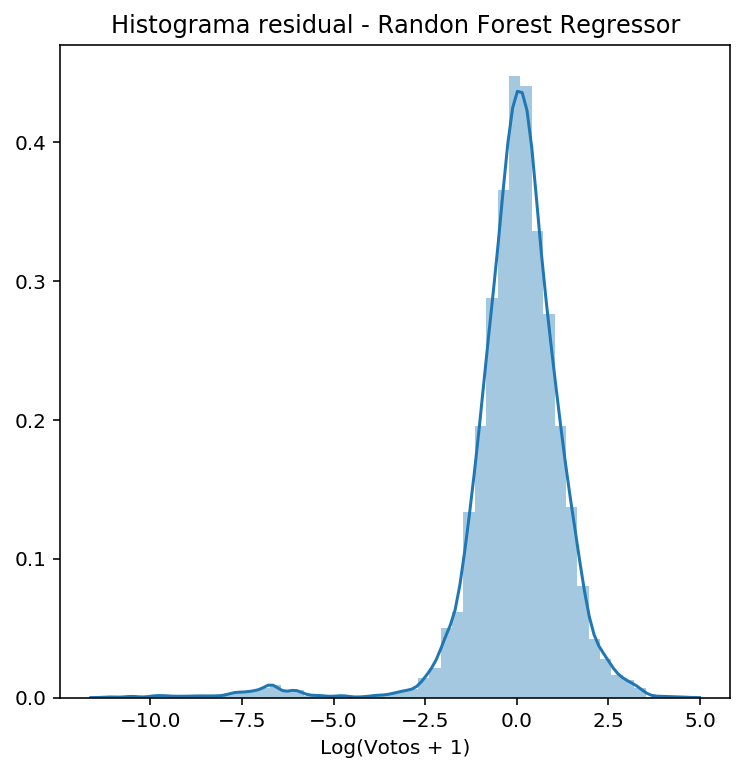

In [87]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - rfr_predict),bins=50)
ax.set_title('Histograma residual - Randon Forest Regressor')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Modelo SVR

In [88]:
# Iportando as bibliotecas necessárias
from sklearn.svm import SVR

In [89]:
# Parametrizando o modelo
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=1.0)
#svr_model = SVR(kernel='linear', C=1e3, gamma=0.1, epsilon=1.0)

In [90]:
# Ajustando o modelo
svr_model.fit(X_train,y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.0, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [91]:
# Predição do modelo
svr_predict = svr_model.predict(X_test)

#### Metricas de avaliação do modelo

In [92]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_predict)))

RMSE: 1.5372122990955224


In [93]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, svr_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.5457855204904476


#### Visualizações

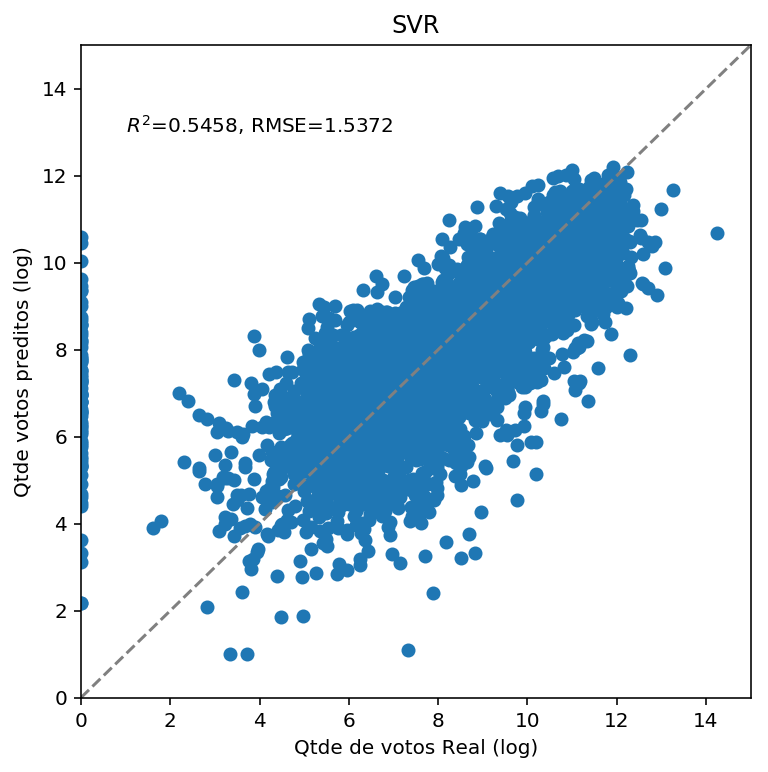

In [94]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, svr_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('SVR')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, svr_predict), np.sqrt(metrics.mean_squared_error(y_test, svr_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

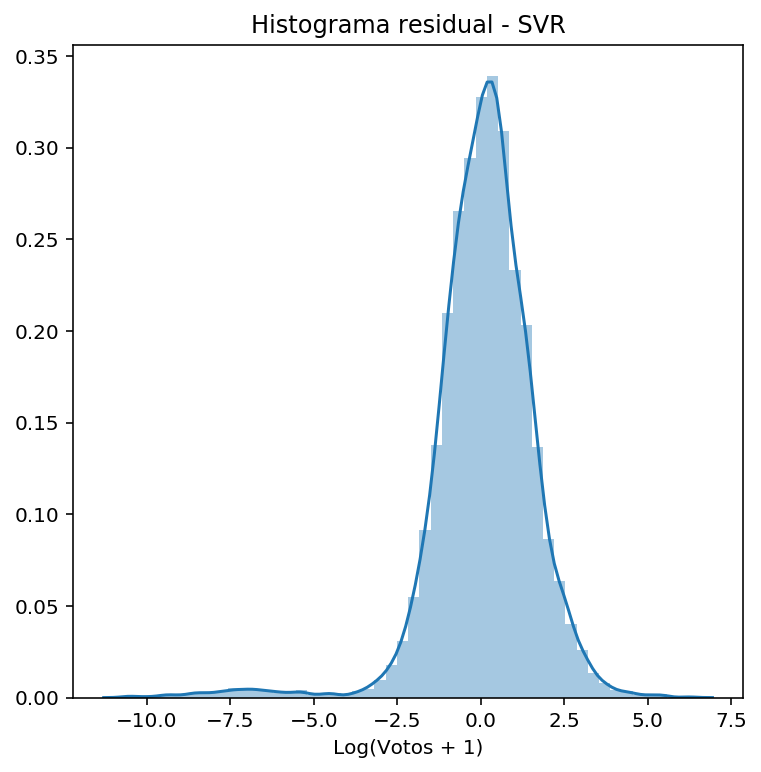

In [95]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - svr_predict),bins=50)
ax.set_title('Histograma residual - SVR')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Regression trees

In [96]:
# Iportando as bibliotecas necessárias
from sklearn.tree import DecisionTreeRegressor

In [97]:
# Parametrizando o modelo
rt_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=100)

In [98]:
# Ajustando o modelo
rt_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=100,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [99]:
# Predição de instancias 
rt_predict = rt_model.predict(X_test)

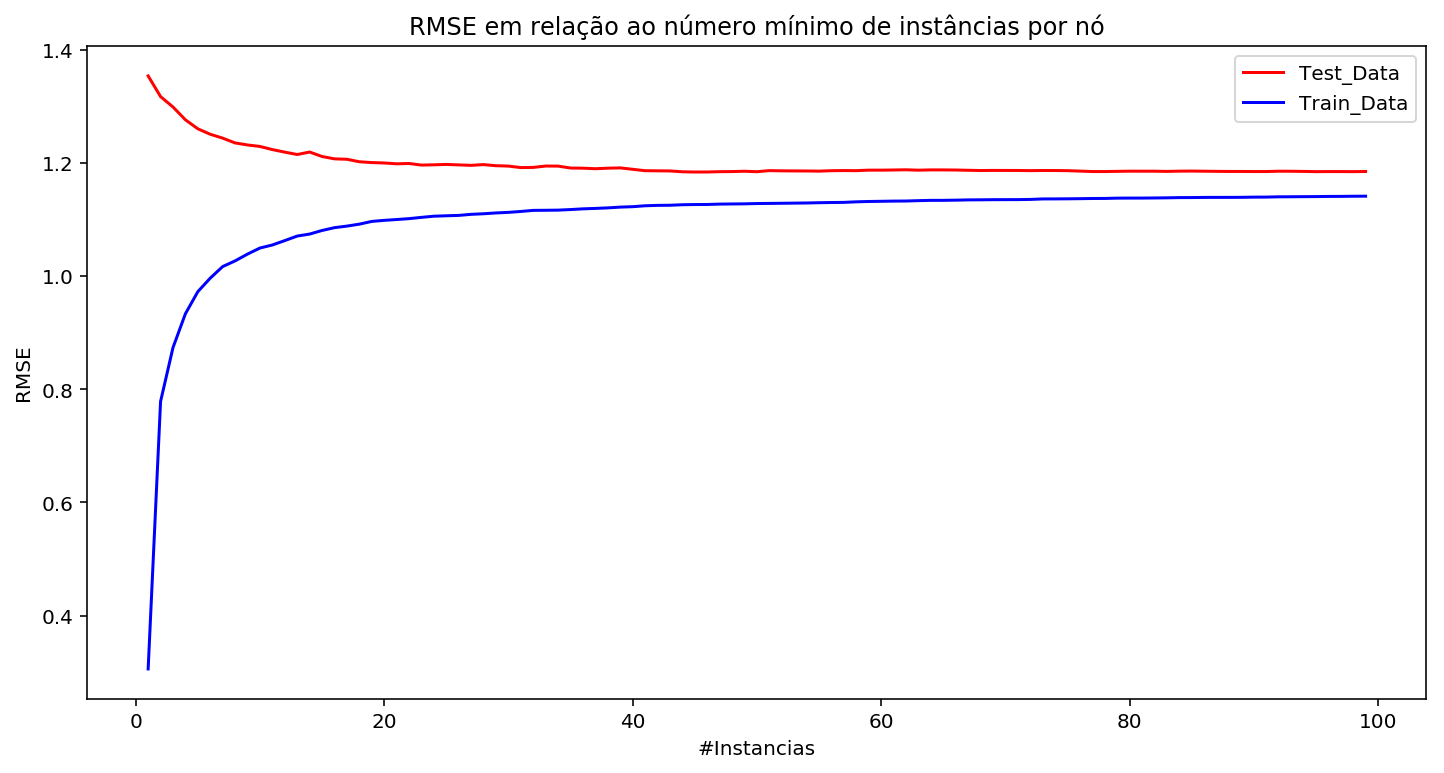

In [100]:
# Plotar o RMSE em relação ao número mínimo de instâncias
 
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
for i in range(1,100):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    rt_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    rt_model.fit(X_train,y_train)
    #Predict query instances
    predicted_train = rt_model.predict(X_train)
    predicted_test = rt_model.predict(X_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(np.sum(np.sqrt(metrics.mean_squared_error(y_train, predicted_train)))))
    RMSE_test.append(np.sqrt(np.sum(np.sqrt(metrics.mean_squared_error(y_test, predicted_test)))))
   
ax0.plot(range(1,100),RMSE_test,label='Test_Data', color='r')
ax0.plot(range(1,100),RMSE_train,label='Train_Data', color='b')
ax0.legend()
ax0.set_title('RMSE em relação ao número mínimo de instâncias por nó')
ax0.set_xlabel('#Instancias')
ax0.set_ylabel('RMSE')
plt.show()

#### Métricas de avaliação do modelo

In [101]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rt_predict)))

RMSE: 1.4055595568220312


In [102]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, rt_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.6202552501191146


#### Visualizações

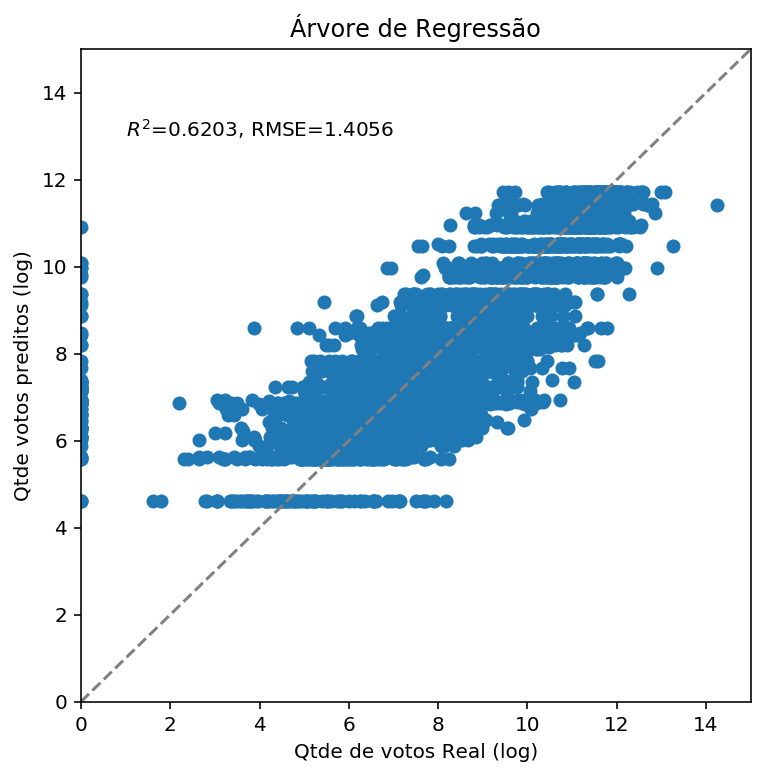

In [103]:
# Gráfico de dispersão
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, rt_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Árvore de Regressão')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, rt_predict), np.sqrt(metrics.mean_squared_error(y_test, rt_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

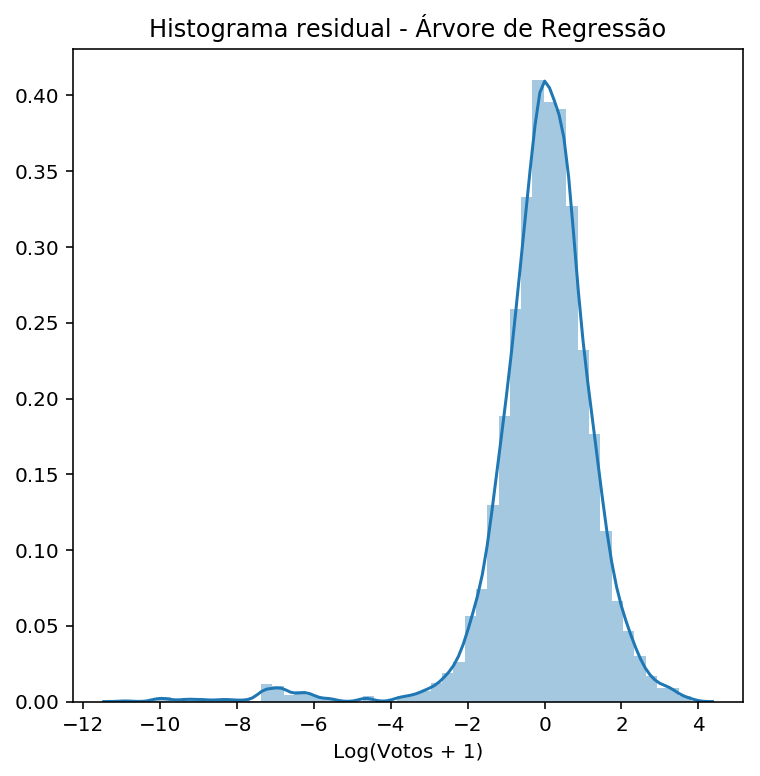

In [104]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - rt_predict),bins=50)
ax.set_title('Histograma residual - Árvore de Regressão')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Resultados

In [105]:
# Retorna as métricas
def metrica(yt, pred):
    rmse = np.sqrt(metrics.mean_squared_error(np.expm1(yt), np.expm1(pred))).astype(int)
    r2 = metrics.r2_score(yt, pred)
    return(rmse, r2)

In [106]:
# Resultados
resultados = {'Regressão Linear sem regularização':{'rmse': metrica(y_test, lm_predict)[0],
                                                    'r-quadrado': metrica(y_test, lm_predict)[1]},  
              'Regressão Linear com RIDGE':{'rmse': metrica(y_test, ridge_predict)[0],
                                            'r-quadrado': metrica(y_test, ridge_predict)[1]}, 
              'Regressão Linear com LASSO':{'rmse': metrica(y_test, lasso_predict)[0],
                                            'r-quadrado': metrica(y_test, lasso_predict)[1]}, 
              'KNN Regressor':{'rmse': metrica(y_test, knn_predict)[0],
                               'r-quadrado': metrica(y_test, knn_predict)[1]}, 
              'Random Forest Regressor':{'rmse': metrica(y_test, rfr_predict)[0],
                                         'r-quadrado': metrica(y_test, rfr_predict)[1]}, 
              'SVR':{'rmse': metrica(y_test, svr_predict)[0],
                     'r-quadrado': metrica(y_test, svr_predict)[1]}, 
              'Regression trees':{'rmse': metrica(y_test, rt_predict)[0],
                                  'r-quadrado': metrica(y_test, rt_predict)[1]}
             }

In [108]:
# Métricas para a avaliação dos modelos
metricas = pd.DataFrame(resultados).T.sort_values(by=['rmse'])
metricas.to_csv('Eleicoes/metricas_modelo2006_2010_2014.csv')
metricas

,r-quadrado,rmse
Random Forest Regressor,0.645016,32997.0
KNN Regressor,0.616291,34123.0
Regression trees,0.620255,34329.0
Regressão Linear com LASSO,0.650532,36281.0
Regressão Linear com RIDGE,0.651481,36409.0
Regressão Linear sem regularização,0.651464,36909.0
SVR,0.545786,39019.0


## Conclusões

Dos modelos avaliados, aplicados nos dados referente à votação dos deputados nas eleições de 2006, 2010 e 2014, chegamos as seguintes conclusões:

 - Todos os modelos avaliados conseguiram estimar no máximo 65% da variável alvo (votos).
 - O modelo **Random Forest Regressor** apresentou **menor RMSE** que os demais modelos.
 - Os modelos com regressão linear tiveram um desempenho muito próximo, sendo o modelo com *regularização LASSO* o que apresentou o *menor RMSE*.
 - Dentre os modelos avaliados o que apresentou menor desempenhro foi o *SVR*, com *maior RMSE* e *menor R²*.